# TBBL Impedance Data Analysis
By: Jian Ruan <br />
Time: June 9, 2022 <br />
Goal: Automate IDE impedance data analysis process. Avoid copy & paste!

## Follow these steps for Accelerated Aging Testing!
### Impedance Measurement
Step 1: Turn on Autolab and connect to the lab Dell PC. <br /><br />
Step 2: Setup the IDE in the Ferrari Cage. <br />

For old IDEs (12, 16, 20):<br />
1) Open the cap.<br /> 
2) Put PBS inside the cap.<br /> 
3) Put wire inside PBS. Make sure the wire is not touching the intricate device.<br /> 
4) Connect CE (Counting Electrode) to mutual / shunt wire.<br /> 
5) Connect WE (Working Electrode) to 2/4/8/16 wire.<br /> 

For new IDEs (22+):<br />
1) Remove the tape on the cap. <br /> 
2) Insert water into the tube with needle.<br /> 
3) Put wire inside the tube through the hole on the cap.<br /> 
4) Tilt the tube to see if there's any air bubble. If yes, insert more water to make sure the tube is filled. <br /> 
5) Connect WE (Working Electrode) to 2/4/8/16 wire.<br /> 

Step 3: Open Nova2.1.4 software with the procedure **"FRA MUX 1ch 50mV 10k-10Hz - automated"**. <br /><br />
Step 4: Change the export file-name to corresponding IDE. <br /> E.g: <br />12-8-m means IDE 12, 8µm, mutual. <br /> 16-16-s means IDE 16, 16µm, shunt <br /><br />
Step 5: Click on the run button and wait for the test result.<br /><br />
Step 6: Nova2.1.4 will auto-generate a csv file for each IDE in the ASCI format. File location:Desktop/IDE-data. <br /><br />
Step 7: Edit the **"date.csv"** file to keep track of the experiment dates. <br /><br />
Step 8: Clean the IDE and put it back to the Lab Armor. <br />

For all IDEs:<br />
1) Make sure the tube is filled full with solution.<br />
2) If new IDE: Add new tape on the hole of the cap to prevent water evaporation.
3) Wrap the device with sealing. Stretch the sealing to ensure close contact. 
4) Spray oil on the tube and the incubator to prevent device getting stuck. 
5) Add covers on the incubator to ensure heat preservation.


### Data Analysis 
Step 1: Open the jupyter notebook on terminal. <br /><br />
Step 2: Open the file **"[20220609]TBBL-Impedance Data Analysis"**.  <br /><br />
Step 3: Run Jupyter Notebook and get your awesome data graphs!

In [1]:
# Step 0: Import library & Check system requirement
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

mpl.rc('axes', labelsize=16, titlesize=20)

# Python Version Requirement
print("Matplotlib Version", mpl.__version__)  #> 3.0.0

# Set global varaible for Z reduction
GLOBAL_Z0_m_dry = []
GLOBAL_Z0_m_wet = []
GLOBAL_Z0_s_wet = []
GLOBAL_dry = 29500000
GLOBAL_wet = 17300000
GLOBAL_ratio = float(GLOBAL_wet / GLOBAL_dry)

# Step 1: Define IDE as a class for recurring use.
class IDE:
    def __init__(self, name, miu_m, capa, data_format):
        """ 
            Built-in function to intialize the IDE object
            self: no need to put in parameters, built-in structures in Python Class
            name: a string, the  number of the IDE (E.g IDE-12)
            miu_m: a list, tested channels (E.g: [2,4,8,16])
            capa: a list, type of capacidance ("m": mutual, "s": shunt)
            data_format: a string, file format ("csv")
        """
        # Initialize IDE object
        self.name = name
        self.miu_m = miu_m
        self.capa = capa
        self.data_format = data_format
        self.data_list = []
        self.num_channels = 0
        
    def setData(self):
        """
        Auto-generate a list of data file for each IDE
        E.g:
            IDE_20 = IDE(20, [2,16], ["m","s"], "csv")
            Will generate
            data_list = [ 
                "20-2-m.csv",
                "20-2-s.csv",
                "20-16-m.csv",
                "20-16-s.csv"]
            Totally 4 data .csv files for IDE_20.
        """
        for m in self.miu_m:
            for c in self.capa:
                file_name = str(self.name) + "-" + str(m) + "-" + c + "." + self.data_format
                self.data_list.append(file_name)
        
        #Number of tested channels
        self.num_channels = len(self.data_list)
    
    def getDataFile(self):
        """
        Return the list of data files for certain device.
        """
        return self.data_list
    
    def getName(self):
        """
        Return the name of certain IDE
        """
        return "IDE-" + str(self.name)
    
    def cleanData(self, df):
        """
        Remove redudant data. Only keep the first 25 lines of data generated by Autolab.
        df: a Panda dataframe, all data for an IDE. With the following key parameters:
        Frequency (Hz), Z (Ω), Phase (°), Output Rs.R (Ω), Output Rct.R (Ω), Output C.C (F)
        """
        # Add one row for checking if the freq is in the first row
        
        for idx, row, in df.iterrows():
            # idx is the index of the row
            # row is a Series: Frequency f = row[0], Impedance Z = row[1], -Phase = row[2]
            # Resistance Rs = row[3], Rct = row[4], Capacitance C = row[5]

            if "Frequency" in row[0]:
                idx_stamp = idx

            if (idx - idx_stamp) > 25:
                # For our impedance testing, only the first 25 data are important. Delete the useless data. 
                df = df.drop(idx)
        
        #Export cleaned data
        df.to_csv(file, index=False)
    
    def plot_imped_phase(self, file, df, df_date, date_idx, Rs, Rct, C):
        """
        Plot 2 key graphs. 1) Impedance vs Frequency 2) Phase vs Frequency
        
        IDE_name: name of IDE
        df: Panda dataframe, from data file e.g 12-8-m.csv
        df_date: .csv file, experimental dates for all IDEs.
        date_idx: identify the index of IDE in the df_date file. 
        Rs: Surface resistance
        Rct: Charge transfer resistance
        C: Capacitance
        """
        
        # iloc[1:27, 0] means row 1 to 27, and colum 0
        date_list = df_date.iloc[date_idx, 1:]
        #datetime.date(2022, 5, 31)

        # Create the IDE Graph Canvas (1 row, 2 coluns)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20), constrained_layout=True)
        fig.suptitle('IDE-' + file[:-4], fontsize = 30)

        # Set the axis scales & both axes to log scale
        ax1.set(xlim=(10, 100000), ylim=(0.1, 100000000000), xscale="log", yscale="log")
        ax1.set_xlabel("F (Hz)", fontsize=20)
        ax1.set_ylabel("Z (Ω)", fontsize=20)
        ax1.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax1.set_title('Impedance vs Frequency', fontsize = 16)

        ax2.set(xlim=(10, 100000), ylim =(-100, 100), xscale ="log")
        ax2.set_xlabel("F (Hz)", fontsize=20)
        ax2.set_ylabel("-Phase (°)", fontsize=20)
        ax2.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax2.set_title('Phase vs Frequency', fontsize = 16)
        
        #Create the Rs, Rct, and C canvas (1 row, 3 columns)
        fig2, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(21, 7), constrained_layout=True)
        
        ax3.set_xlabel("Day", fontsize=20)
        ax3.set_ylabel("Rs (Ω)", fontsize=20)
        ax3.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax3.set_title('Surface Resistance', fontsize = 16)
        
        ax4.set_xlabel("Day", fontsize=20)
        ax4.set_ylabel("Rct (Ω)", fontsize=20)
        ax4.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax4.set_title('Charge Transfer Resistance', fontsize = 16)
        
        ax5.set_xlabel("Day", fontsize=20)
        ax5.set_ylabel("C (F)", fontsize=20)
        ax5.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax5.set_title('Capacitance', fontsize = 16)

        i = 0
        j = 0
        day_idx = 0
        
        #Distinguish mutal vs shunt (mutual has dry, shunt doesn't)
        if date_list[0] == "dry":
            start = date_list[1]
        else:
            start = date_list[0]
        
        start = self.getDatetime(start)
        
        day_actual_list = []
        
        while j < len(df):
            #iterate over df 
            
            i += 1 # ith is Title, Data starts from i+1
            j = i + 25
            x_freq = df.iloc[i:j,0].astype(float) #frequency
            y_imped = df.iloc[i:j,1].astype(float) #impedance
            y_phase = df.iloc[i:j,2].astype(float) #-phase      
            date = date_list[day_idx]
            
            if date == "dry":
                # The device is mutual
                prefix = "Day-0 (dry)"
                day_actual_list.append(0)
                 
            else:
                # The device is shunt
                date = self.getDatetime(date)
                day_diff = date - start
                day_actual = self.getActualDates(day_diff.days, 70.5, 37.0)
                
                if day_diff.days == 0:
                    prefix = "Day-0 (wet)"
                else:
                    prefix = "Day-" + str(day_diff.days) + " (" + str(day_actual) + ")"
                date = date_list[day_idx]
                day_actual_list.append(1 + day_actual)
            
            # Graph 1: Imepdance Z(Ω) vs Frequency(Hz) - labeled by dates
            ax1.plot(x_freq, y_imped, 'o-', label = prefix)
            
            # Graph 2: -Phase(°) vs Frequency(Hz) - labeled by dates
            ax2.plot(x_freq, y_phase, 'o-', label = prefix)
            
            i = j
            day_idx += 1
        
        if 'm' in file:
            df_open = pd.read_csv("m-open.csv")
            df_short = pd.read_csv("m-wet-short.csv")
        elif "s" in file:
            df_open = pd.read_csv("s-open.csv")
            df_short = pd.read_csv("s-wet-short.csv")
                       
        x_freq_open = df_open.iloc[1:, 0].astype(float) #frequency
        y_imped_open = df_open.iloc[1:, 1].astype(float) #impedance
        y_phase_open = df_open.iloc[1:, 2].astype(float) #-phase
            
        x_freq_short = df_short.iloc[1:, 0].astype(float) #frequency
        y_imped_short = df_short.iloc[1:, 1].astype(float) #impedance
        y_phase_short = df_short.iloc[1:, 2].astype(float) #-phase
        
        #print(y_imped_open.values)
        #print(y_imped_short.values)
        
        # Get the threshold of open and short for shunt
        ax1.plot(x_freq_open, y_imped_open, '^-', label = "Open", color= 'black')
        ax1.plot(x_freq_short, y_imped_short, '^-', label = "Short", color= 'black')
        
        ax2.plot(x_freq_open, y_phase_open, '^-', label = "Open", color= 'black')
        ax2.plot(x_freq_short, y_phase_short, '^-', label = "Short", color= 'black')
            
        ax3.plot(day_actual_list, Rs, marker='o')
        ax4.plot(day_actual_list, Rct, marker='o')
        ax5.plot(day_actual_list, C, marker='o')
        
        ax1.legend(loc='upper right', fontsize = 15)
        ax2.legend(loc='upper right', fontsize = 15)
        
        for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
            label.set_fontsize(16)
        for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            label.set_fontsize(16)
        for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
            label.set_fontsize(16)
        for label in (ax4.get_xticklabels() + ax4.get_yticklabels()):
            label.set_fontsize(16)
        for label in (ax5.get_xticklabels() + ax5.get_yticklabels()):
            label.set_fontsize(16)
        
        ax4.yaxis.offsetText.set_fontsize(16)
        ax5.yaxis.offsetText.set_fontsize(16)
        
        # Extract impedance only at 1K Hz.
        self.plot_impe_freq(file, df, [1000, 100,  215.44, 10000], day_actual_list)
            
        plt.show()
        return None
    
    def extractImped(self, df, freq):
        """
        Extract certain freq's impedance result for Z/Z0 ratio.
        df: Panda dataframe, from data file e.g 12-8-m.csv
        freq: int, wanted frequency
        """
        impe_freq = []
        for idx, row, in df.iterrows():
            # idx is the index of the row
            # row is a Series: Frequency f = row[0], Impedance Z = row[1], -Phase = row[2]
            # Resistance Rs = row[3], Rct = row[4], Capacitance C = row[5]
            if "Frequency" not in row[0]:
                if float(row[0]) == freq:
                    impe_freq.append(float(row[1]))
        return impe_freq
    
    def plot_impe_freq(self, file, df, freq_list, day_actual_list):
        """
        file: the file name
        df: Panda dataframe, from data file e.g 12-8-m.csv
        freq_list: list of frequency we want to compare.
        """
        # Plot impedance change with respect to time
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), constrained_layout=True)
        ax1.set_xlabel("Day", fontsize=20)
        ax1.set_ylabel("Z (Ω)", fontsize=20)
        ax1.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax1.set_title('Impedance Change At Different Frequency', fontsize = 16)
        
        
        ax2.set_xlabel("Day", fontsize=20)
        ax2.set_ylabel("Z / Z0", fontsize=20)
        ax2.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax2.set_title('Impedance Change At 1000 Hz, IDE Specific Criteria', fontsize = 16)
        
        ax3.set_xlabel("Day", fontsize=20)
        ax3.set_ylabel("Z / Z0", fontsize=20)
        ax3.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax3.set_title('Impedance Change At 1000 Hz, Universal Criteria', fontsize = 16)
        
        imped_freq_1K = []
        ratio = []
        GLOBAL_ratio = []
        
        for freq in freq_list:
            imped_freq = self.extractImped(df, freq)
            if freq == 1000:
                imped_freq_1K = imped_freq
            ax1.plot(day_actual_list, imped_freq, label = str(freq) + "Hz", marker='o')
        
        if 'm' in file:
            start_wet = imped_freq_1K[1]
            GLOBAL_Z0_m_dry.append(imped_freq_1K[0])
            GLOBAL_Z0_m_wet.append(start_wet)
        elif "s" in file:
            start_wet = imped_freq_1K[0]
            GLOBAL_Z0_s_wet.append(start_wet)
        
        for imped in imped_freq_1K:
            ratio.append(imped / start_wet)
            GLOBAL_ratio.append(imped / GLOBAL_wet)
            
        ax2.plot(day_actual_list, ratio, label = "1000 Hz",  marker='o')  
        ax2.axhline(y = 1, label = "1", color = 'r', linestyle='dotted')
        ax2.axhline(y = 1.2, label = "1.2", color = 'b', linestyle='dotted')
        ax2.axhline(y = 0.33, label = "0.33", color = 'g', linestyle='dotted')

        ax3.plot(day_actual_list, GLOBAL_ratio, label = "1000 Hz",  marker='o')  
        ax3.axhline(y = 1, label = "1", color = 'r', linestyle='dotted')
        ax3.axhline(y = 1.2, label = "1.2", color = 'b', linestyle='dotted')
        ax3.axhline(y = 0.33, label = "0.33", color = 'g', linestyle='dotted')
        
        for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
            label.set_fontsize(16)
        for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            label.set_fontsize(16)
        for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
            label.set_fontsize(16)
            
        ax1.yaxis.offsetText.set_fontsize(16)
        
        ax1.legend(loc='upper right', fontsize = 20)
        ax2.legend(loc='upper right', fontsize = 20)
        ax3.legend(loc='upper right', fontsize = 20)
        
        plt.show()
        print('\n \n')
        
    def getRC(self, df, value):
        """
        Get the table of R / C over time
        df: Panda dataframe
        value: Rs, Rct, or C
        """
        data = []
        idx = 0
        
        if value == "Rs":
            idx = 3
        if value == "Rct":
            idx = 4
        if value == "C":
            idx = 5
        # remove strings
        
        j = 1
        while j <= len(df):
            data.append(float(df.iloc[j,idx]))
            
            j = j + 26
        return data
    
    def getActualDates(self, day_diff, room_temp, device_temp):
        """
        Convert experimental dates to real dates.
        
        day_diff: day, number of days since Day-0-wet
        room_temp: C°, room temperature
        device_temp: C°, device temperature
        """
        # Accelerated Aging Test Formula
        exp = (room_temp - device_temp)/10.0
        factor = 2**(exp)
        day_real = day_diff * factor
        return int(day_real)
    
    def getDatetime(self, m_d_y):
        """
        Convert a string time to a datetime variable to get date difference.
        m_d_y: a string in month, day, year format
        """
        #print(m_d_y)
        time_list = str(m_d_y).split("/")
        #print(time_list)
        date = datetime.date(2022, int(time_list[0]), int(time_list[1]))
        return date

def addNewIDE(start, end):
    """
        Create a list of new IDE with names.
        start: the start number of IDE
        end: the end number of IDE
    """
    L  = []
    for i in range(start, end):
        L.append(str(i) + "-2-m")
        L.append(str(i) + "-2-s")
        L.append(str(i) + "-4-m")
        L.append(str(i) + "-4-s")
        L.append(str(i) + "-8-m")
        L.append(str(i) + "-8-s")
        L.append(str(i) + "-16-m")
        L.append(str(i) + "-16-s")
   
    df_new_IDE = pd.DataFrame(L, columns=['new IDE name'])
        
    #Export a csv file with new IDEs
    df_new_IDE.to_csv("new_IDE.csv", index=False)
    return df_new_IDE

Matplotlib Version 3.3.4


[1.45838116e+06 2.17935960e+06 3.20788880e+06 4.70771339e+06
 7.00959774e+06 1.01499705e+07 1.49702917e+07 2.18753619e+07
 3.19206099e+07 4.66422797e+07 6.89520794e+07 9.95892999e+07
 1.46222428e+08 2.15456603e+08 3.14337245e+08 4.47753461e+08
 6.52777272e+08 9.55383276e+08 1.35657331e+09 1.99901128e+09
 2.89710343e+09 4.54402478e+09 5.70910736e+09 1.03296903e+10
 1.28418826e+10]
[1.15085146e+03 1.43663137e+03 1.84631398e+03 2.39084740e+03
 3.21820708e+03 4.20952360e+03 5.81757613e+03 7.98563876e+03
 1.10319717e+04 1.53340562e+04 2.14802101e+04 2.96883867e+04
 4.10457279e+04 5.68617802e+04 7.86186293e+04 1.08337639e+05
 1.48740883e+05 2.04221968e+05 2.80386352e+05 3.83631767e+05
 5.26157120e+05 7.08288009e+05 9.60703497e+05 1.27195262e+06
 1.73234175e+06]


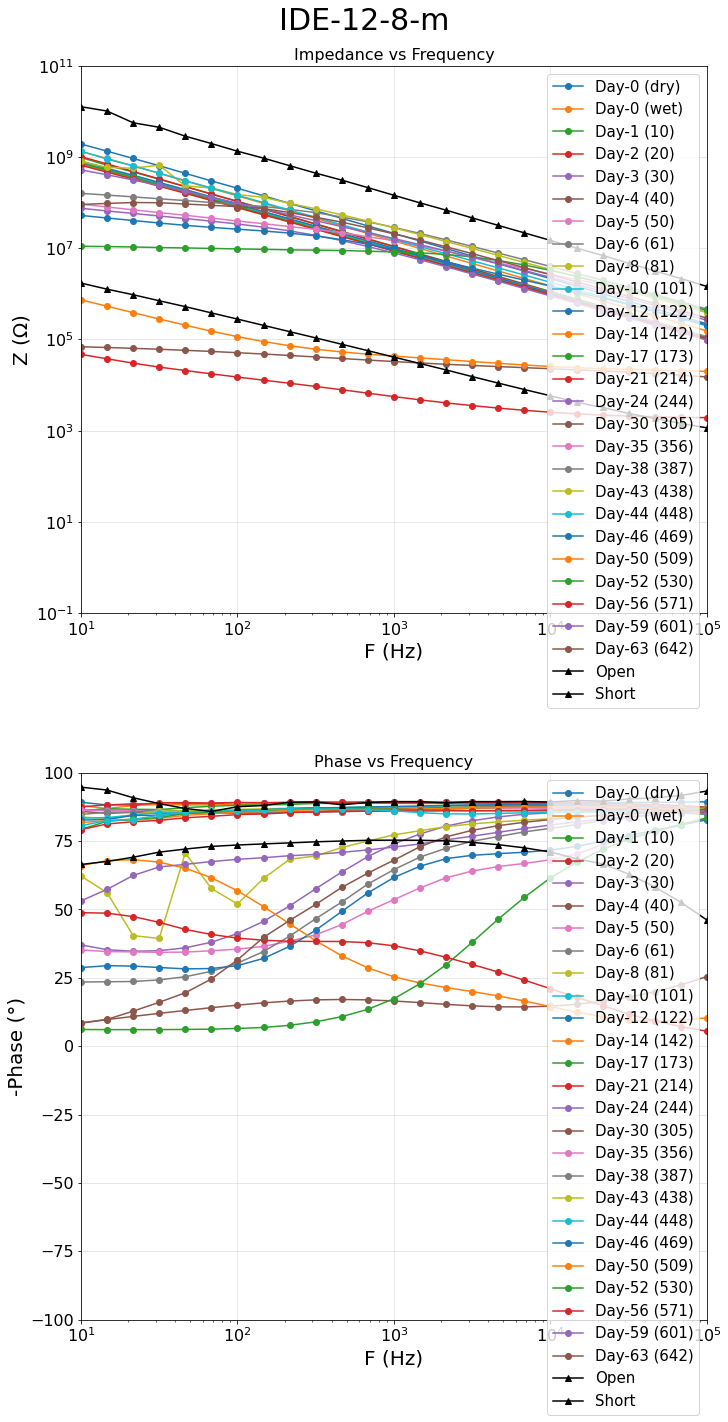

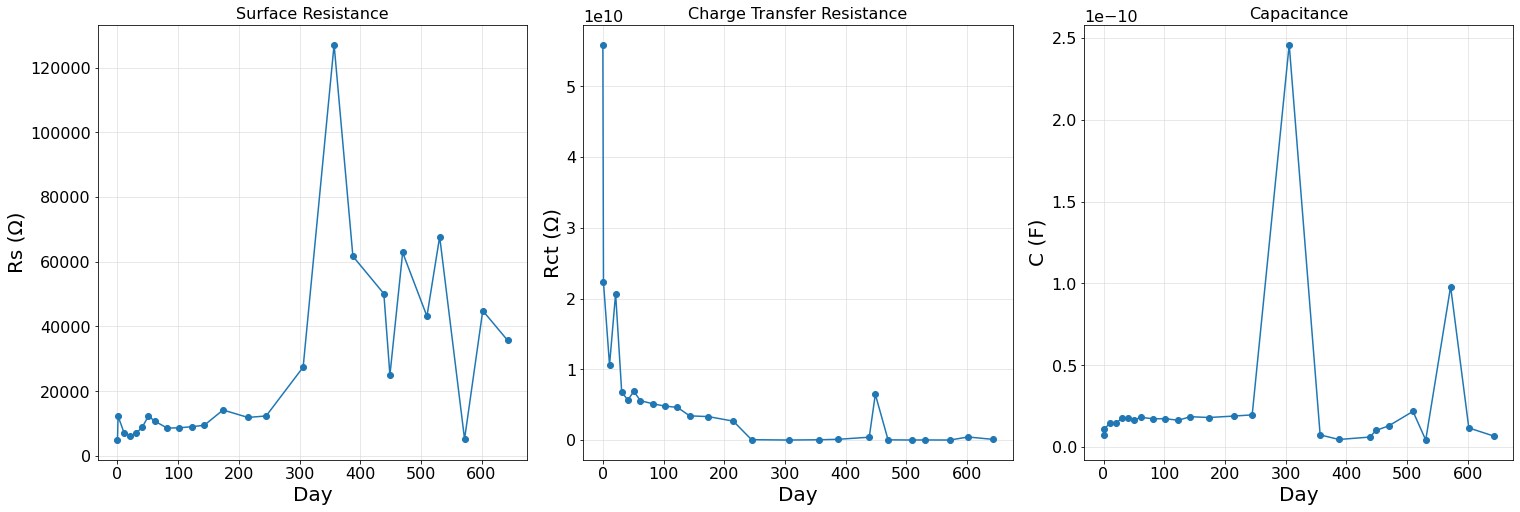

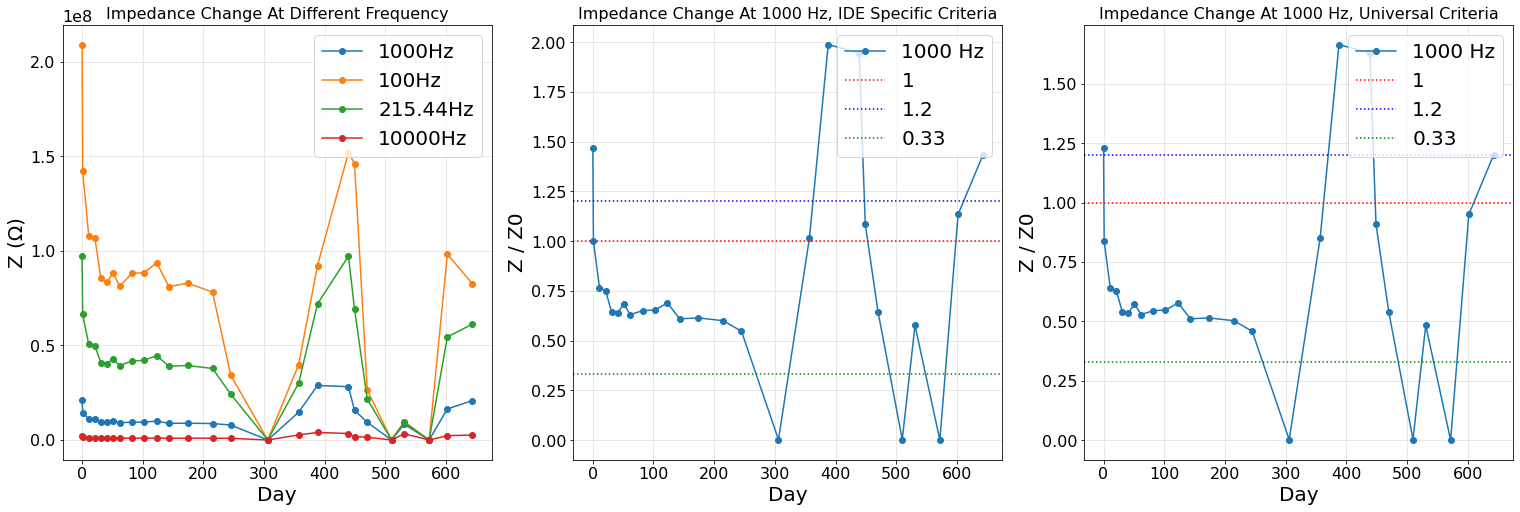


 

[2.56842677e+06 3.95482587e+06 5.86455430e+06 8.72593320e+06
 1.25049776e+07 1.84558128e+07 2.74229612e+07 3.93199588e+07
 5.76106796e+07 8.66437758e+07 1.23102006e+08 1.80568873e+08
 2.66283822e+08 3.92398963e+08 5.64555452e+08 8.43749593e+08
 1.24132132e+09 1.73714498e+09 2.48564883e+09 3.64202209e+09
 5.13641073e+09 8.76002114e+09 1.02092873e+10 1.62389770e+10
 2.57643814e+10]
[   580.6362858    668.8095246    789.0633727    958.0517555
   1194.435944    1534.498968    2009.713448    2625.421851
   3520.437728    4753.233777    6445.621553    8815.649483
  12184.34198    16734.98326    23096.4336     32005.16833
  44303.40628    61350.59253    84485.94383   115903.9019
 158468.5844    217129.0233    294986.7225    396899.9869
 529570.705    ]


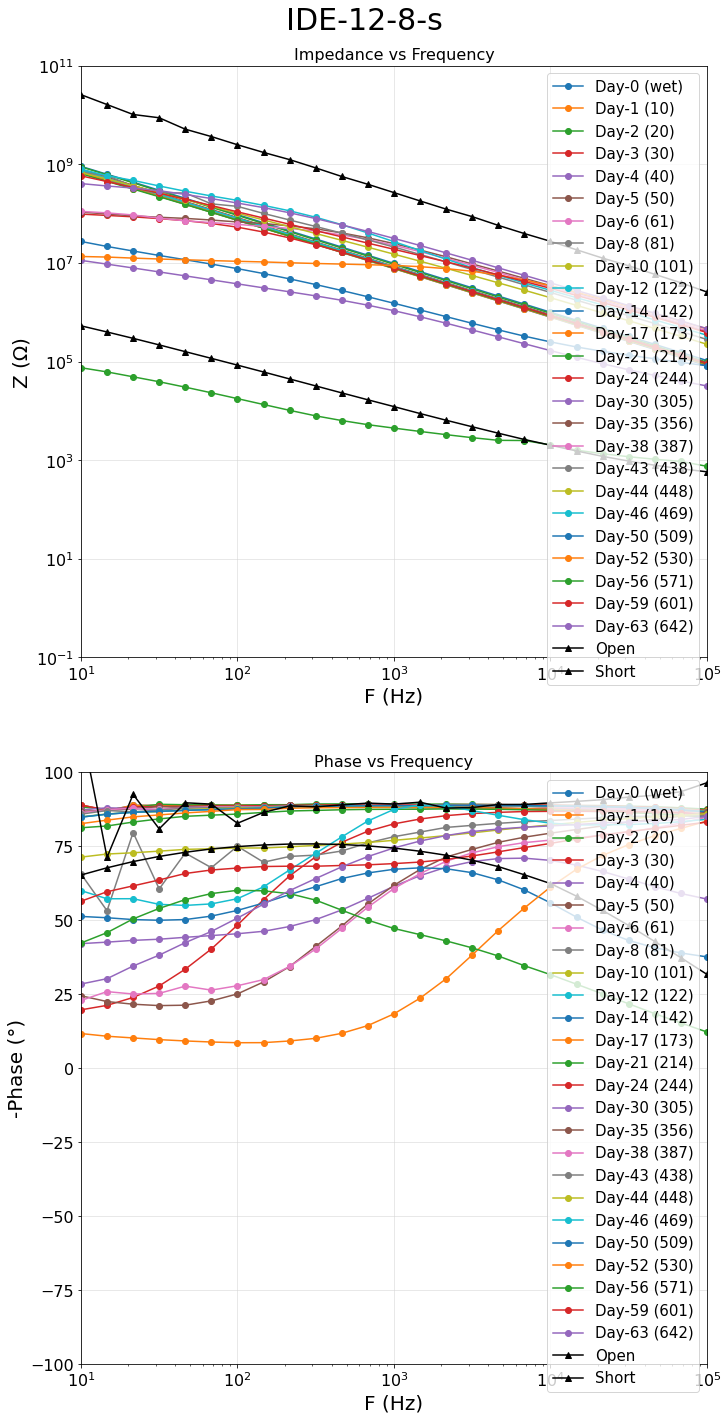

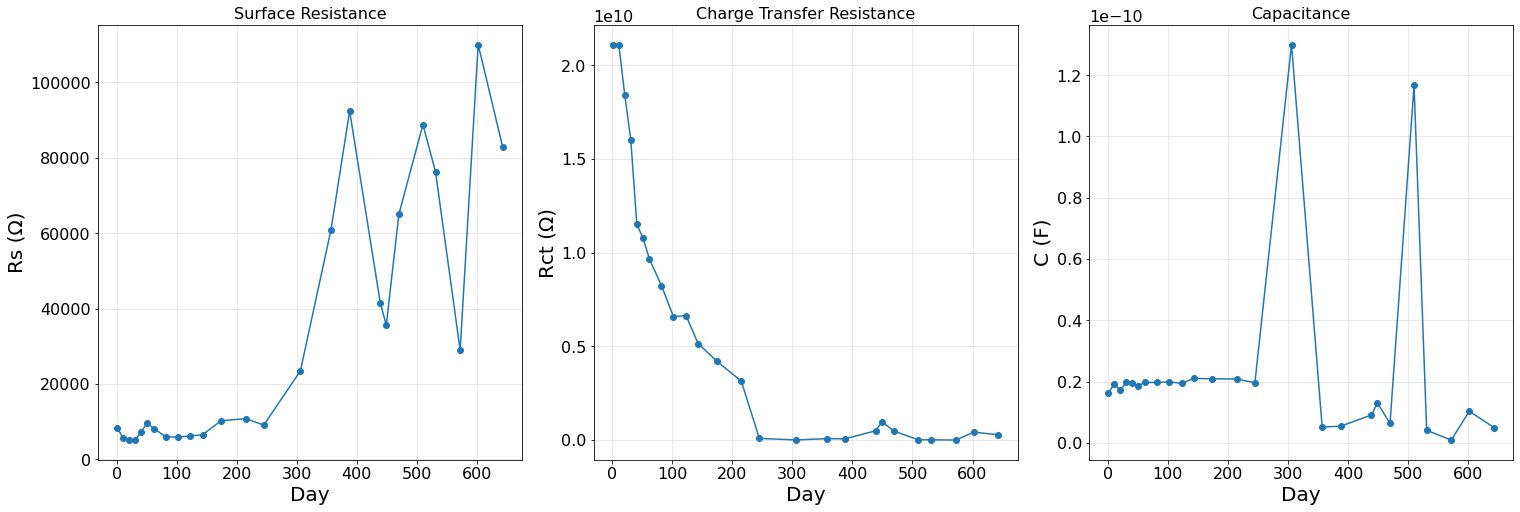

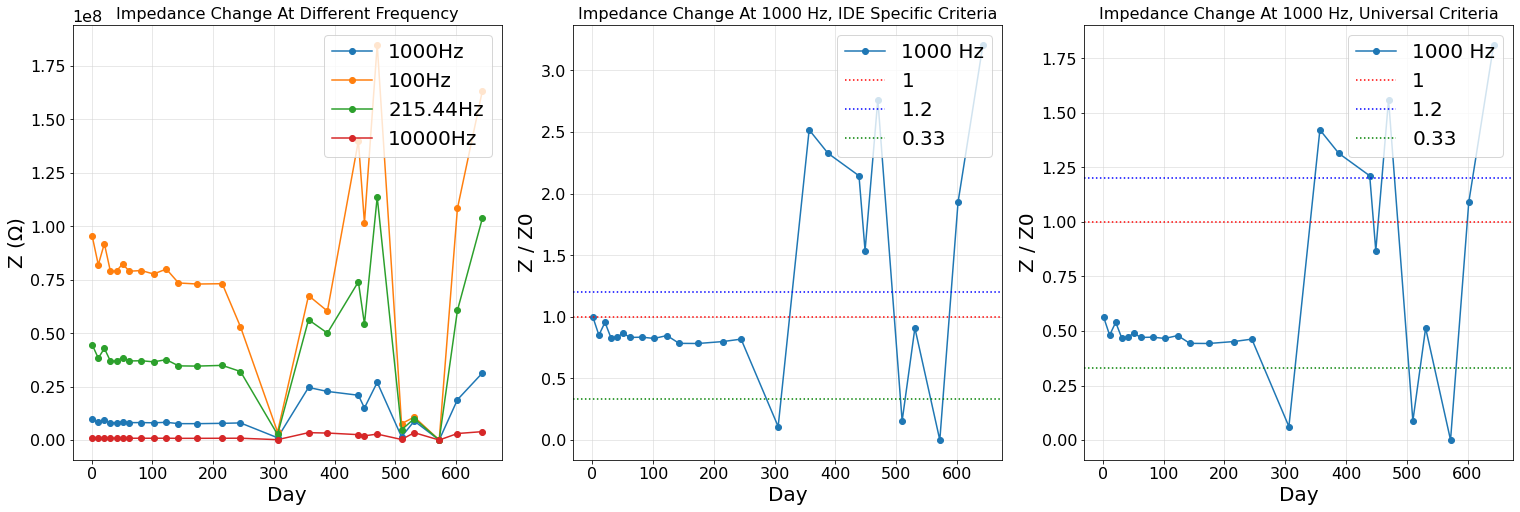


 

[1.45838116e+06 2.17935960e+06 3.20788880e+06 4.70771339e+06
 7.00959774e+06 1.01499705e+07 1.49702917e+07 2.18753619e+07
 3.19206099e+07 4.66422797e+07 6.89520794e+07 9.95892999e+07
 1.46222428e+08 2.15456603e+08 3.14337245e+08 4.47753461e+08
 6.52777272e+08 9.55383276e+08 1.35657331e+09 1.99901128e+09
 2.89710343e+09 4.54402478e+09 5.70910736e+09 1.03296903e+10
 1.28418826e+10]
[1.15085146e+03 1.43663137e+03 1.84631398e+03 2.39084740e+03
 3.21820708e+03 4.20952360e+03 5.81757613e+03 7.98563876e+03
 1.10319717e+04 1.53340562e+04 2.14802101e+04 2.96883867e+04
 4.10457279e+04 5.68617802e+04 7.86186293e+04 1.08337639e+05
 1.48740883e+05 2.04221968e+05 2.80386352e+05 3.83631767e+05
 5.26157120e+05 7.08288009e+05 9.60703497e+05 1.27195262e+06
 1.73234175e+06]


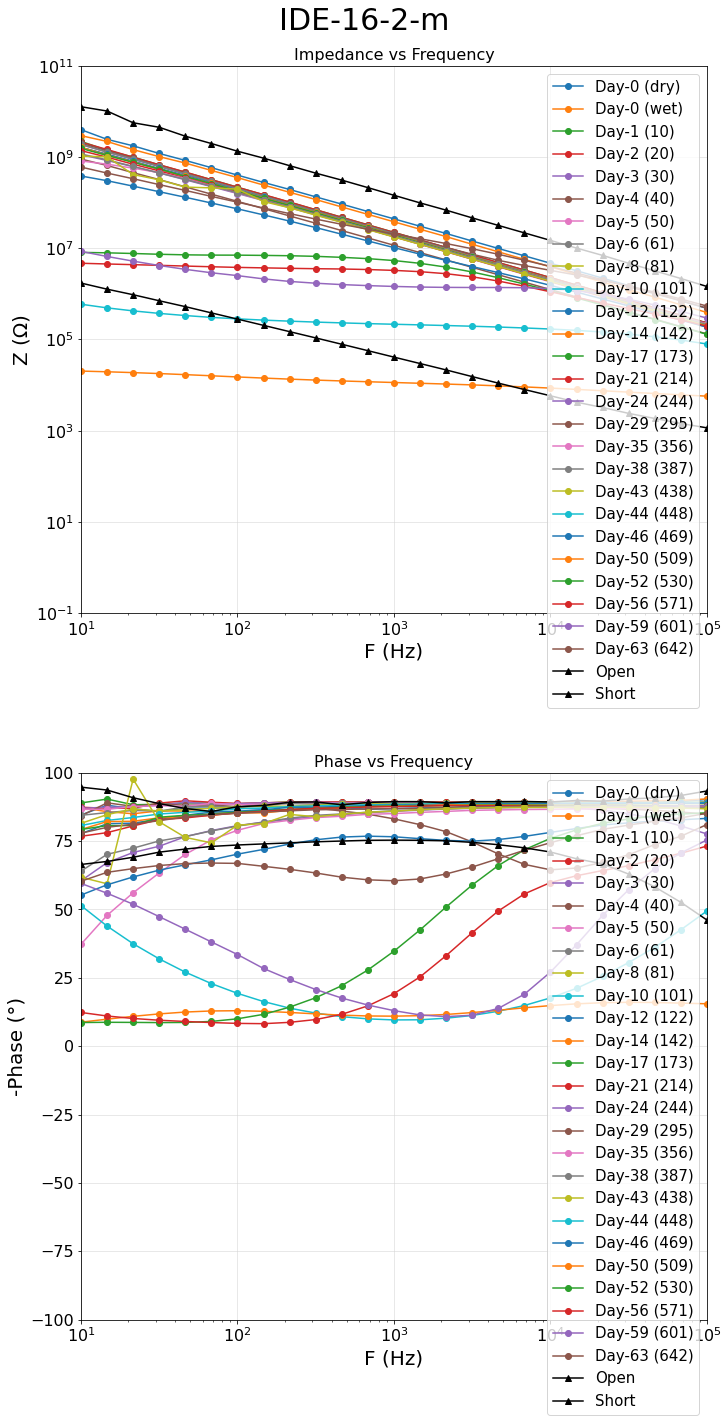

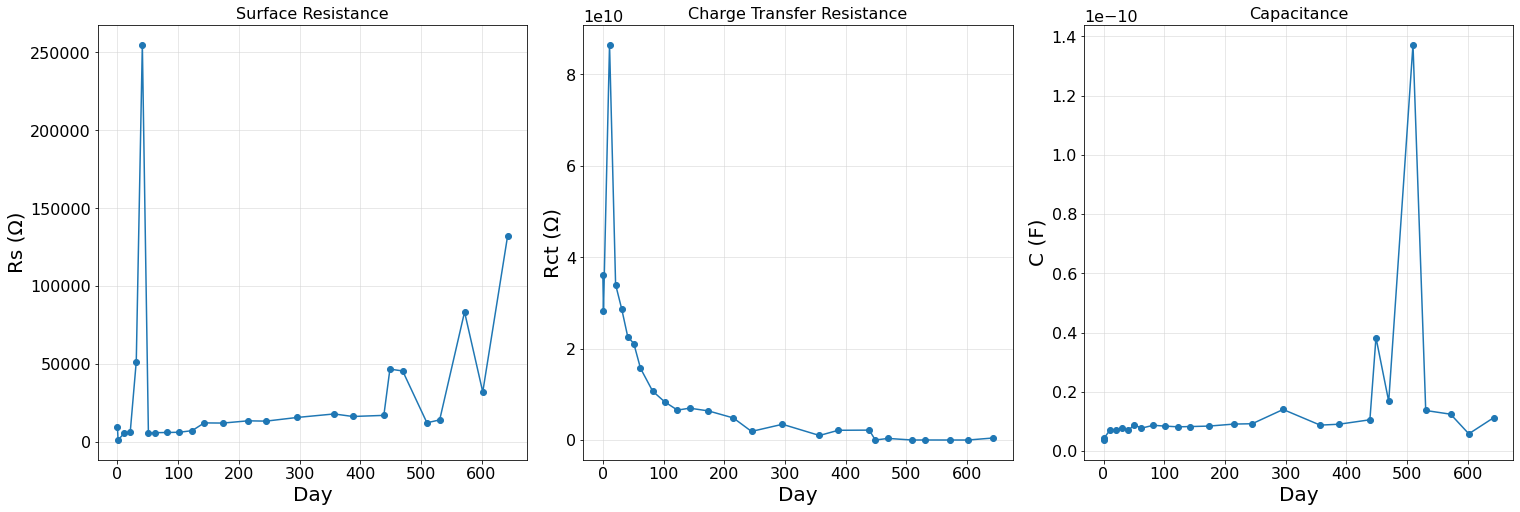

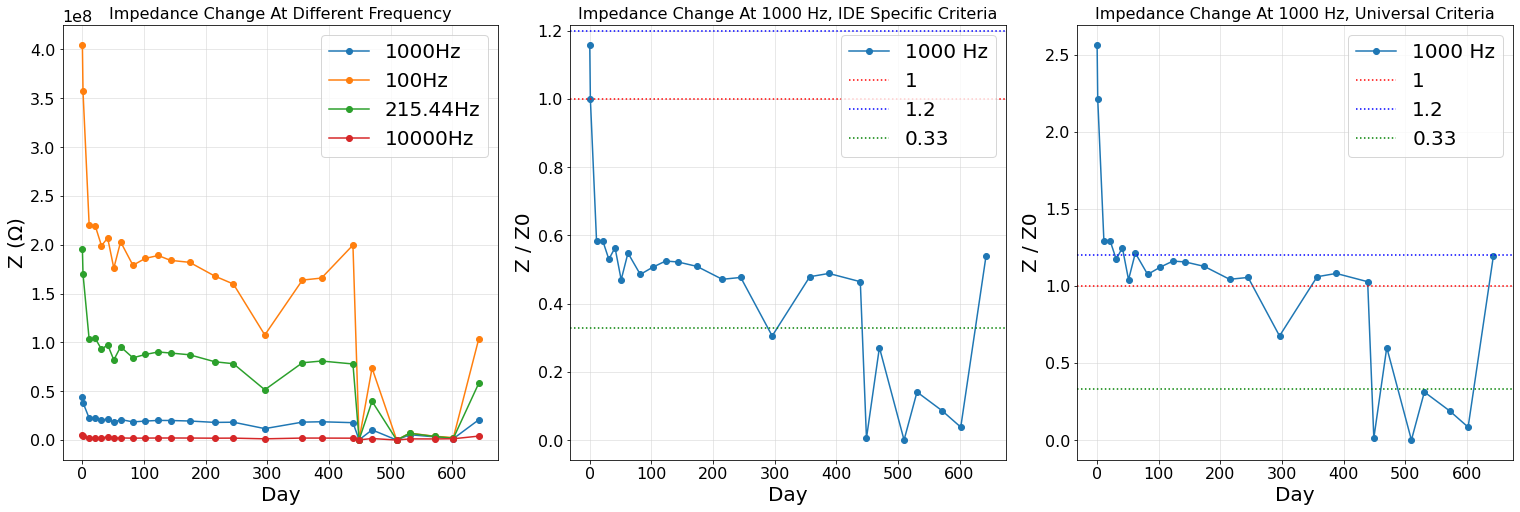


 

[2.56842677e+06 3.95482587e+06 5.86455430e+06 8.72593320e+06
 1.25049776e+07 1.84558128e+07 2.74229612e+07 3.93199588e+07
 5.76106796e+07 8.66437758e+07 1.23102006e+08 1.80568873e+08
 2.66283822e+08 3.92398963e+08 5.64555452e+08 8.43749593e+08
 1.24132132e+09 1.73714498e+09 2.48564883e+09 3.64202209e+09
 5.13641073e+09 8.76002114e+09 1.02092873e+10 1.62389770e+10
 2.57643814e+10]
[   580.6362858    668.8095246    789.0633727    958.0517555
   1194.435944    1534.498968    2009.713448    2625.421851
   3520.437728    4753.233777    6445.621553    8815.649483
  12184.34198    16734.98326    23096.4336     32005.16833
  44303.40628    61350.59253    84485.94383   115903.9019
 158468.5844    217129.0233    294986.7225    396899.9869
 529570.705    ]


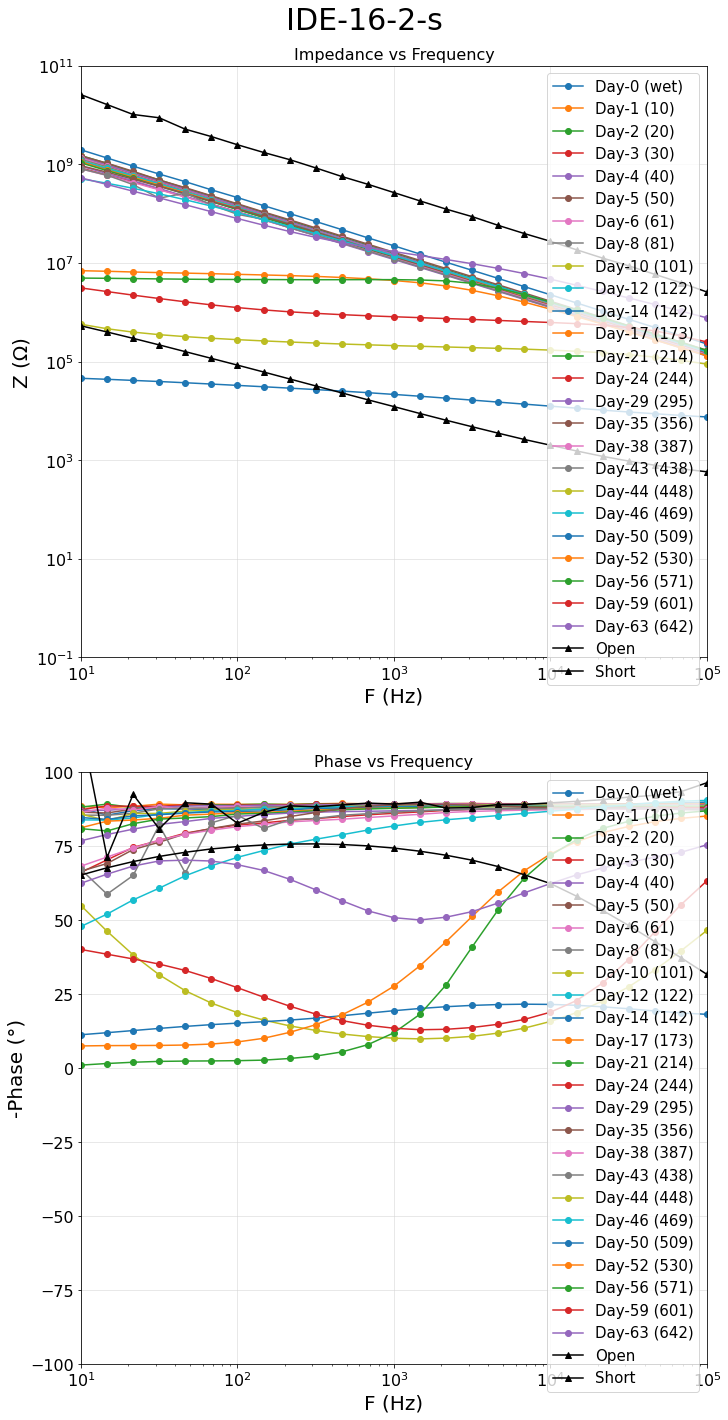

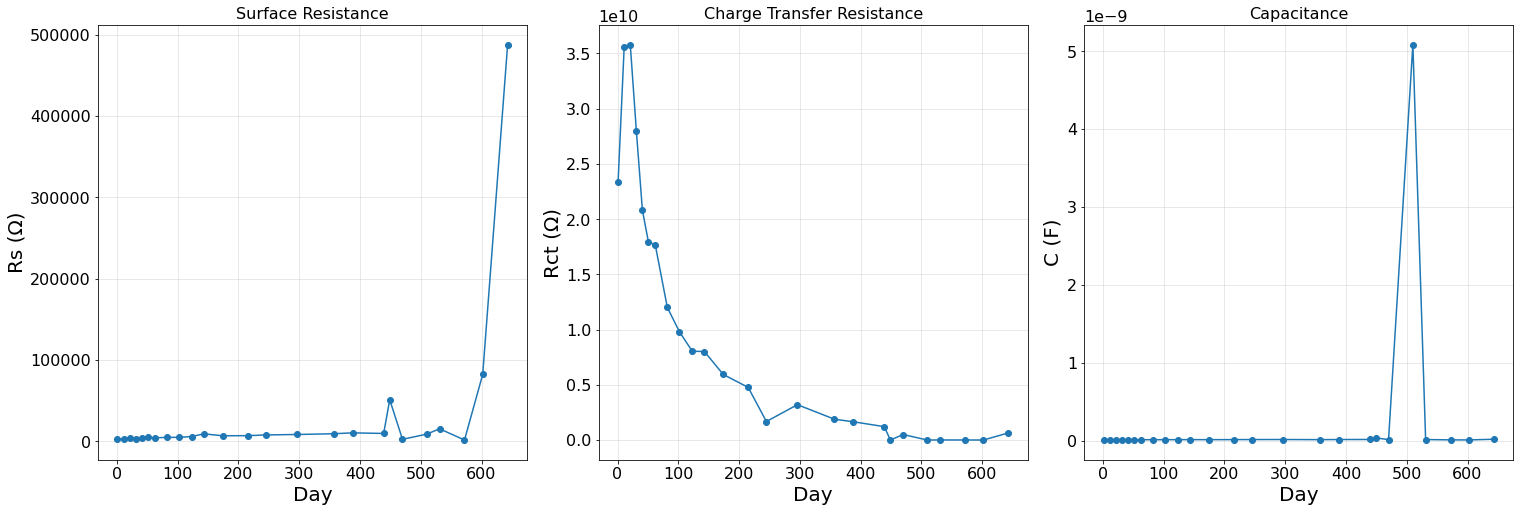

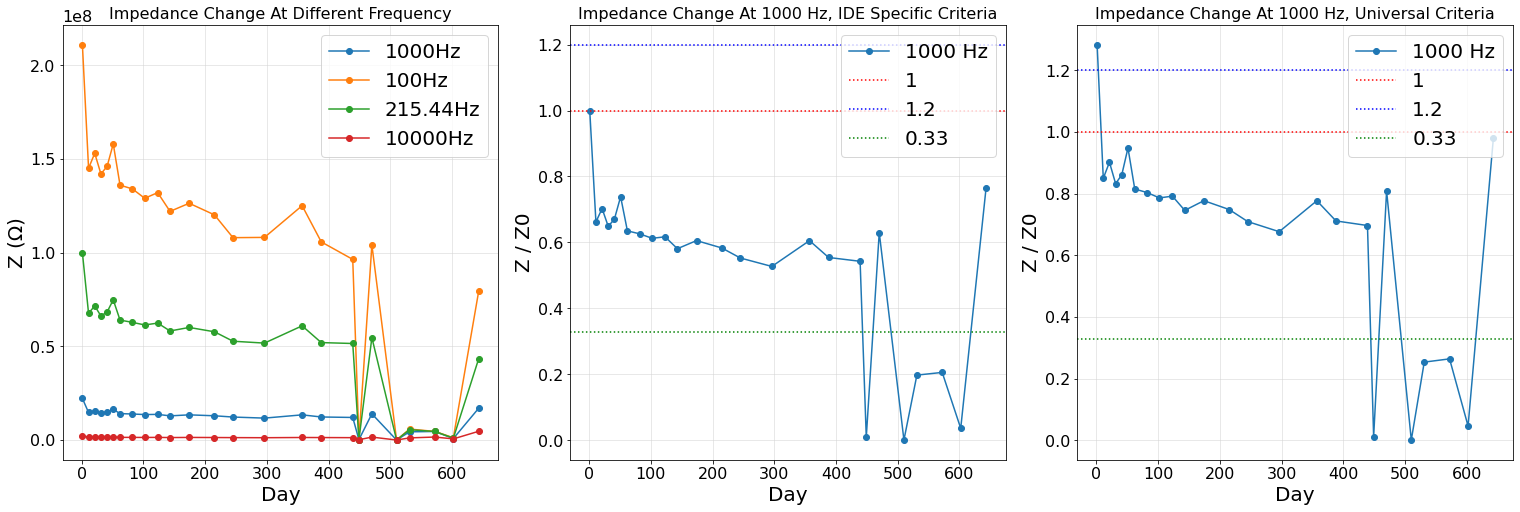


 

[1.45838116e+06 2.17935960e+06 3.20788880e+06 4.70771339e+06
 7.00959774e+06 1.01499705e+07 1.49702917e+07 2.18753619e+07
 3.19206099e+07 4.66422797e+07 6.89520794e+07 9.95892999e+07
 1.46222428e+08 2.15456603e+08 3.14337245e+08 4.47753461e+08
 6.52777272e+08 9.55383276e+08 1.35657331e+09 1.99901128e+09
 2.89710343e+09 4.54402478e+09 5.70910736e+09 1.03296903e+10
 1.28418826e+10]
[1.15085146e+03 1.43663137e+03 1.84631398e+03 2.39084740e+03
 3.21820708e+03 4.20952360e+03 5.81757613e+03 7.98563876e+03
 1.10319717e+04 1.53340562e+04 2.14802101e+04 2.96883867e+04
 4.10457279e+04 5.68617802e+04 7.86186293e+04 1.08337639e+05
 1.48740883e+05 2.04221968e+05 2.80386352e+05 3.83631767e+05
 5.26157120e+05 7.08288009e+05 9.60703497e+05 1.27195262e+06
 1.73234175e+06]


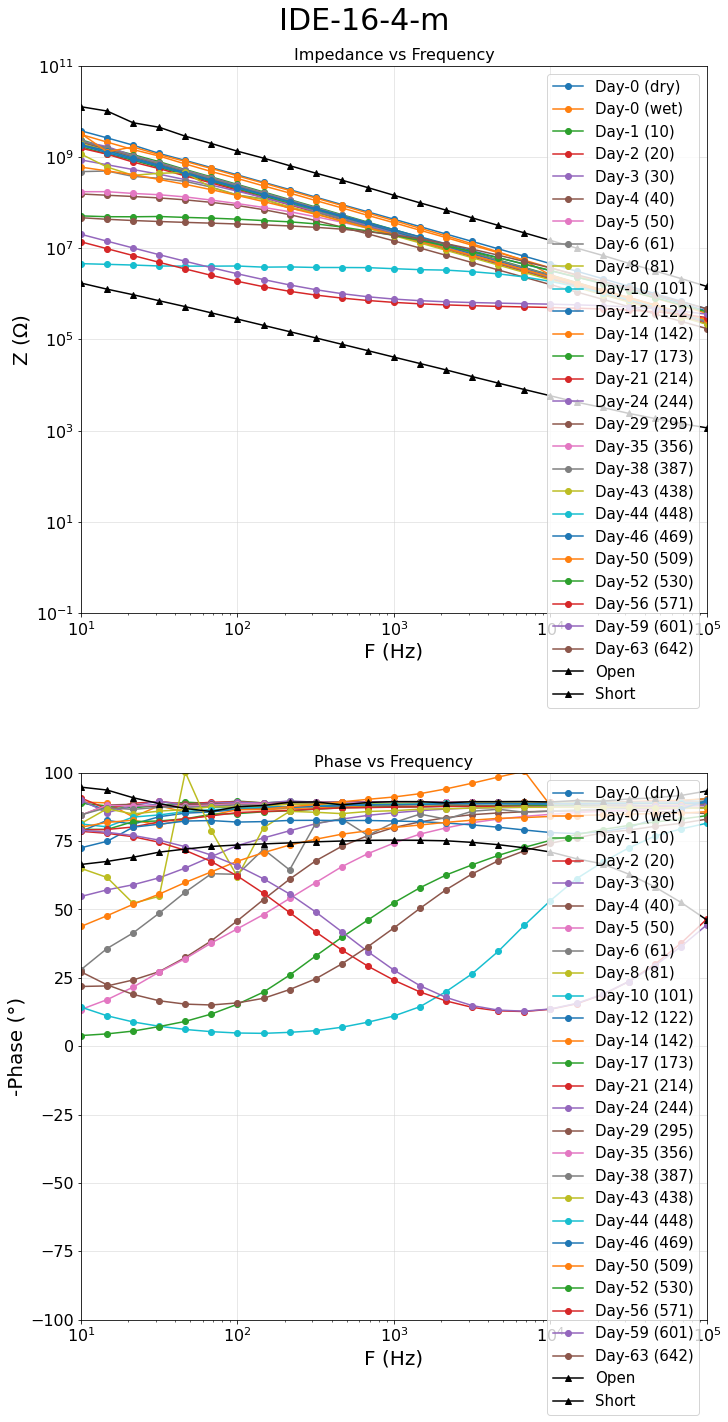

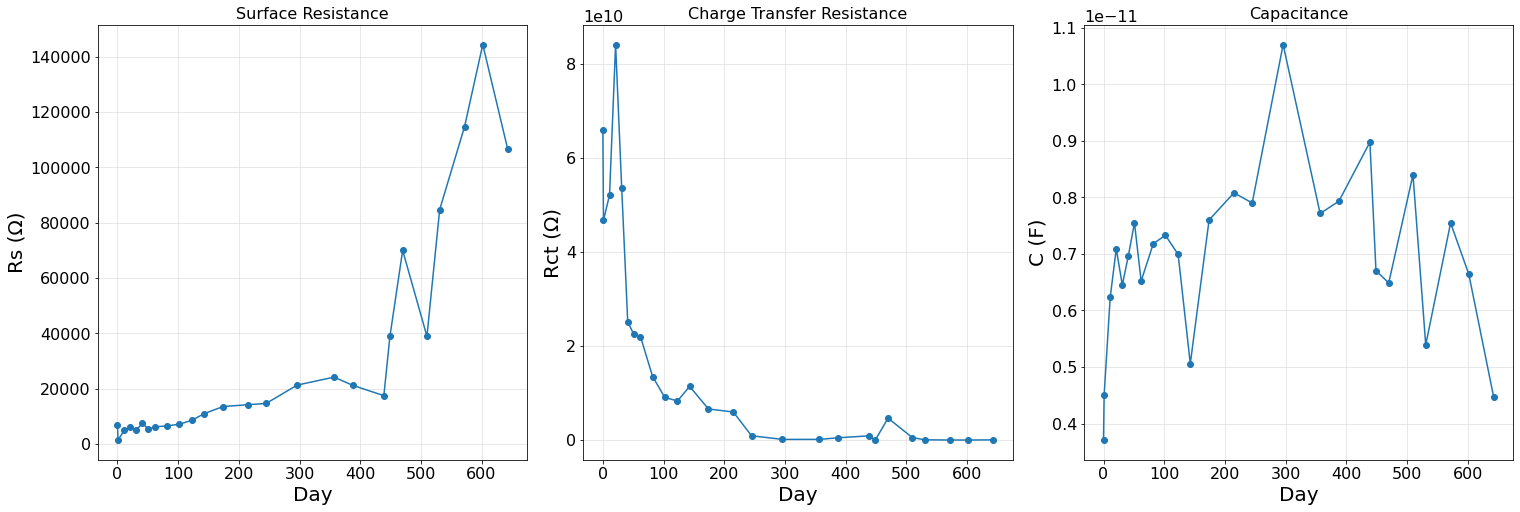

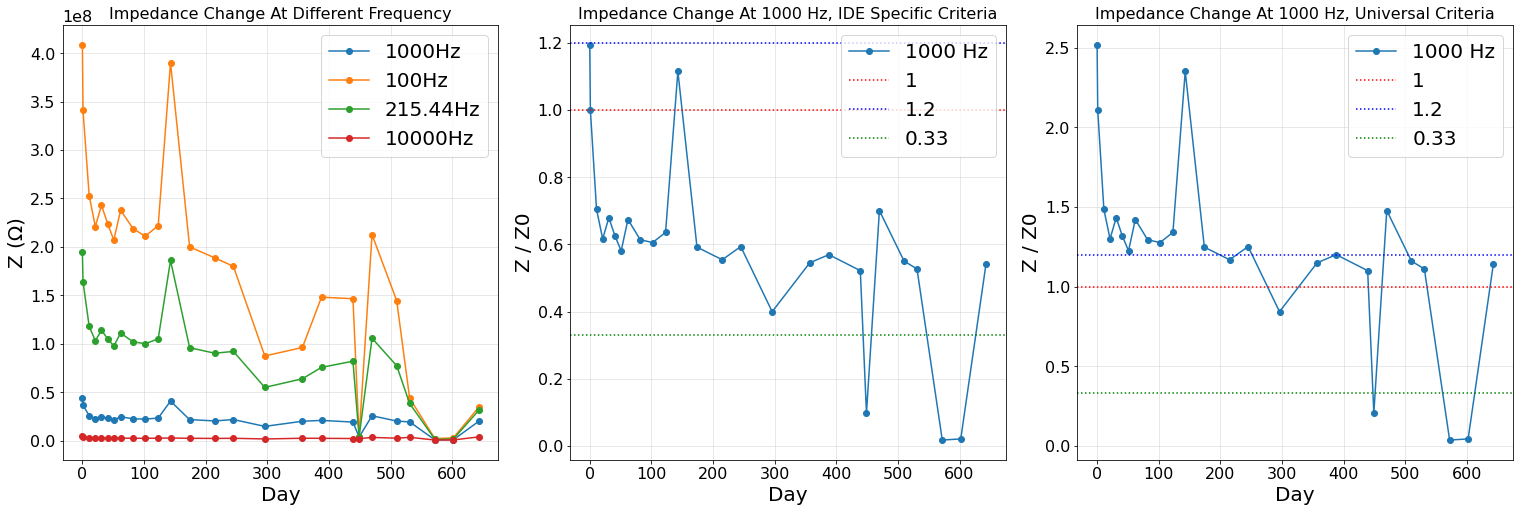


 

[2.56842677e+06 3.95482587e+06 5.86455430e+06 8.72593320e+06
 1.25049776e+07 1.84558128e+07 2.74229612e+07 3.93199588e+07
 5.76106796e+07 8.66437758e+07 1.23102006e+08 1.80568873e+08
 2.66283822e+08 3.92398963e+08 5.64555452e+08 8.43749593e+08
 1.24132132e+09 1.73714498e+09 2.48564883e+09 3.64202209e+09
 5.13641073e+09 8.76002114e+09 1.02092873e+10 1.62389770e+10
 2.57643814e+10]
[   580.6362858    668.8095246    789.0633727    958.0517555
   1194.435944    1534.498968    2009.713448    2625.421851
   3520.437728    4753.233777    6445.621553    8815.649483
  12184.34198    16734.98326    23096.4336     32005.16833
  44303.40628    61350.59253    84485.94383   115903.9019
 158468.5844    217129.0233    294986.7225    396899.9869
 529570.705    ]


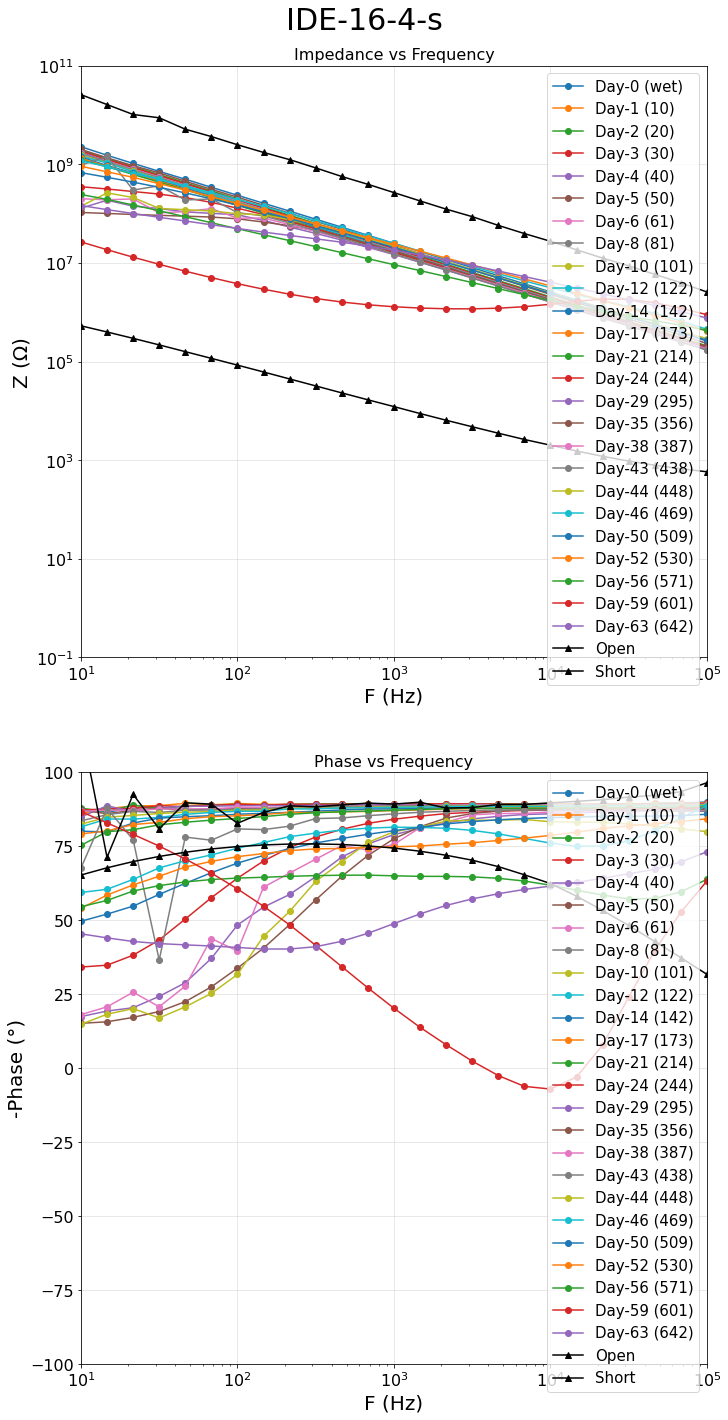

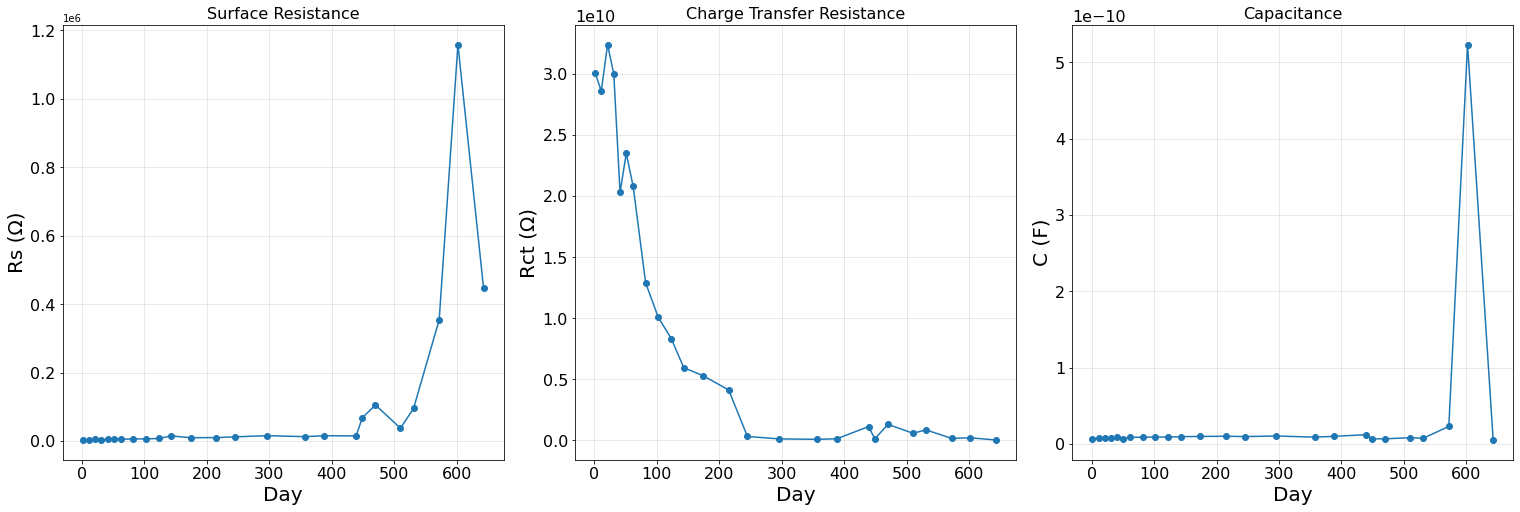

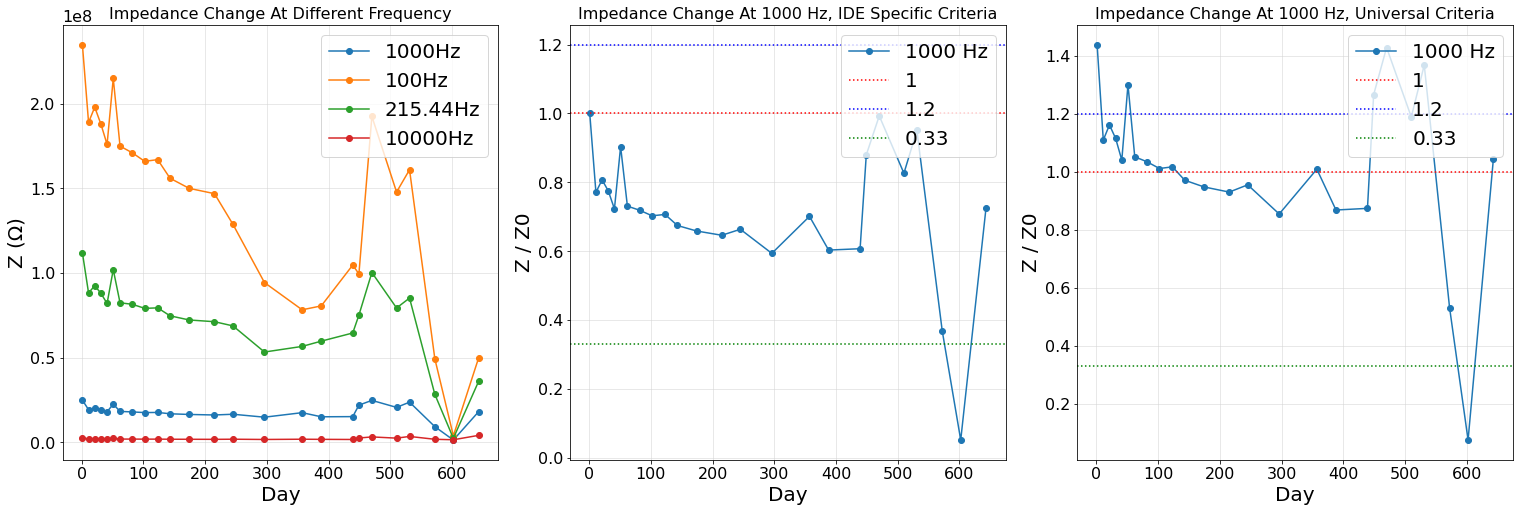


 

[1.45838116e+06 2.17935960e+06 3.20788880e+06 4.70771339e+06
 7.00959774e+06 1.01499705e+07 1.49702917e+07 2.18753619e+07
 3.19206099e+07 4.66422797e+07 6.89520794e+07 9.95892999e+07
 1.46222428e+08 2.15456603e+08 3.14337245e+08 4.47753461e+08
 6.52777272e+08 9.55383276e+08 1.35657331e+09 1.99901128e+09
 2.89710343e+09 4.54402478e+09 5.70910736e+09 1.03296903e+10
 1.28418826e+10]
[1.15085146e+03 1.43663137e+03 1.84631398e+03 2.39084740e+03
 3.21820708e+03 4.20952360e+03 5.81757613e+03 7.98563876e+03
 1.10319717e+04 1.53340562e+04 2.14802101e+04 2.96883867e+04
 4.10457279e+04 5.68617802e+04 7.86186293e+04 1.08337639e+05
 1.48740883e+05 2.04221968e+05 2.80386352e+05 3.83631767e+05
 5.26157120e+05 7.08288009e+05 9.60703497e+05 1.27195262e+06
 1.73234175e+06]


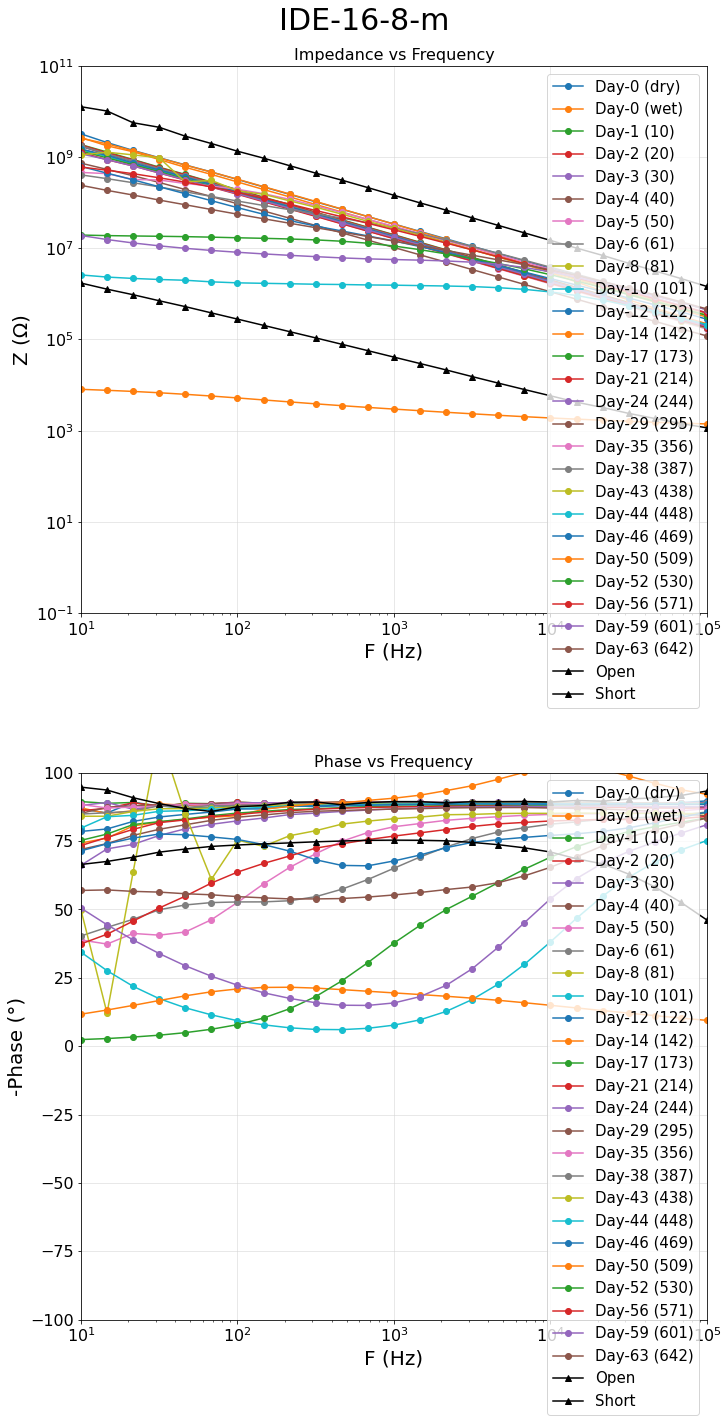

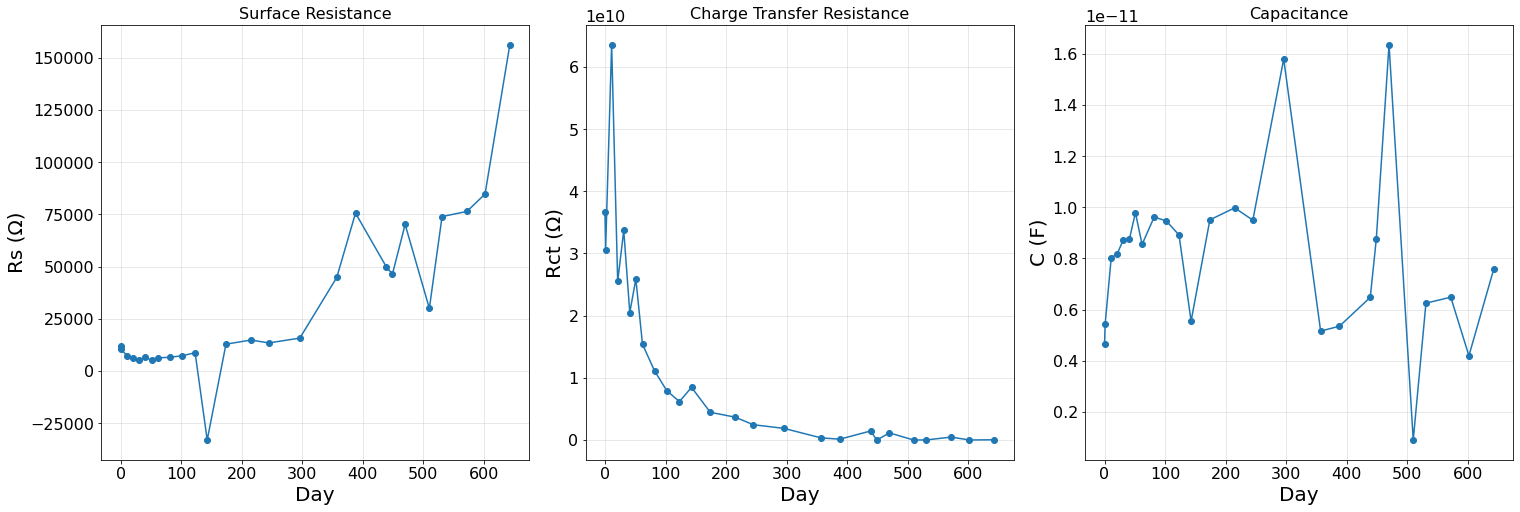

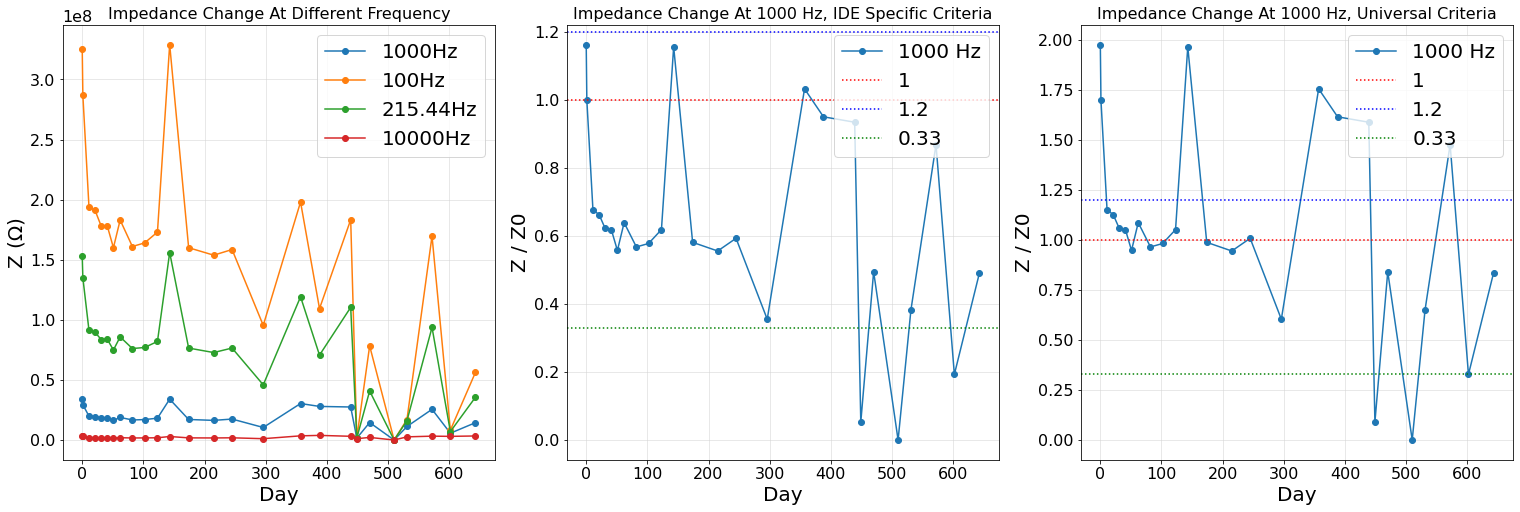


 

[2.56842677e+06 3.95482587e+06 5.86455430e+06 8.72593320e+06
 1.25049776e+07 1.84558128e+07 2.74229612e+07 3.93199588e+07
 5.76106796e+07 8.66437758e+07 1.23102006e+08 1.80568873e+08
 2.66283822e+08 3.92398963e+08 5.64555452e+08 8.43749593e+08
 1.24132132e+09 1.73714498e+09 2.48564883e+09 3.64202209e+09
 5.13641073e+09 8.76002114e+09 1.02092873e+10 1.62389770e+10
 2.57643814e+10]
[   580.6362858    668.8095246    789.0633727    958.0517555
   1194.435944    1534.498968    2009.713448    2625.421851
   3520.437728    4753.233777    6445.621553    8815.649483
  12184.34198    16734.98326    23096.4336     32005.16833
  44303.40628    61350.59253    84485.94383   115903.9019
 158468.5844    217129.0233    294986.7225    396899.9869
 529570.705    ]


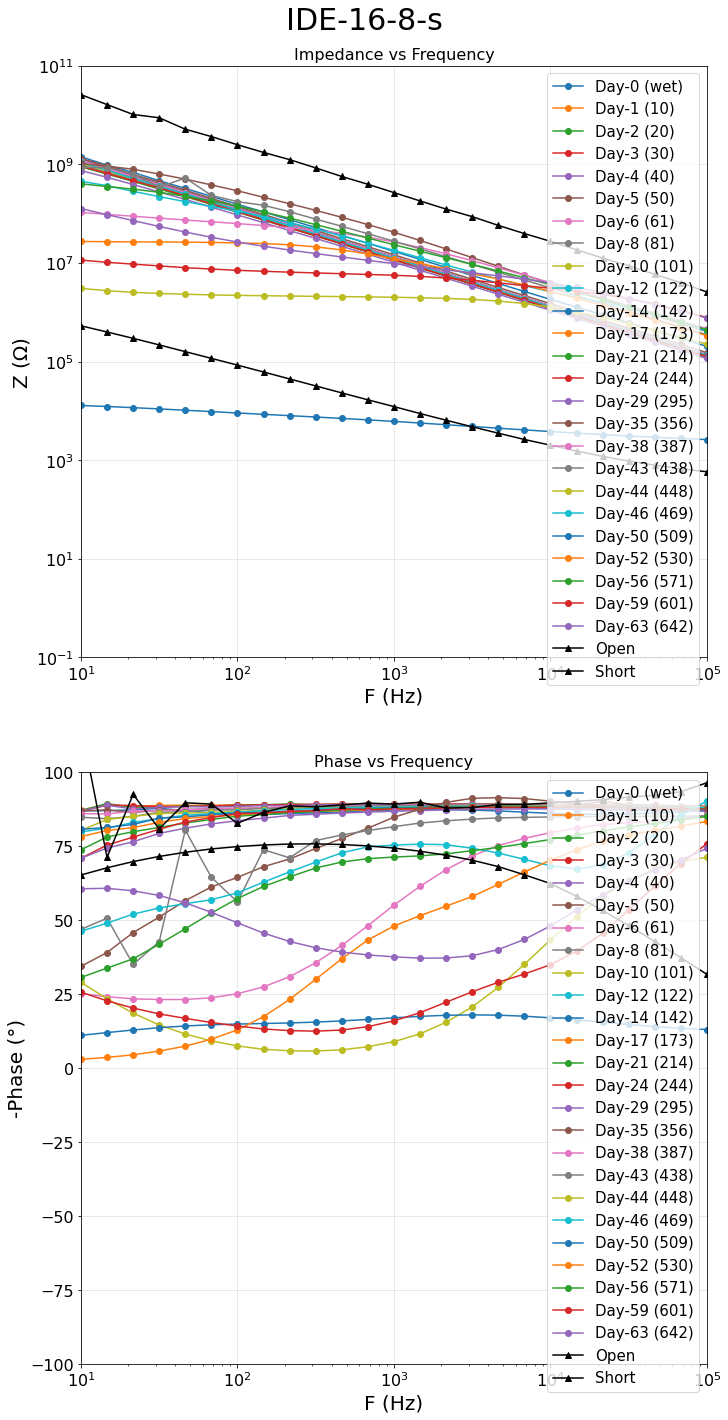

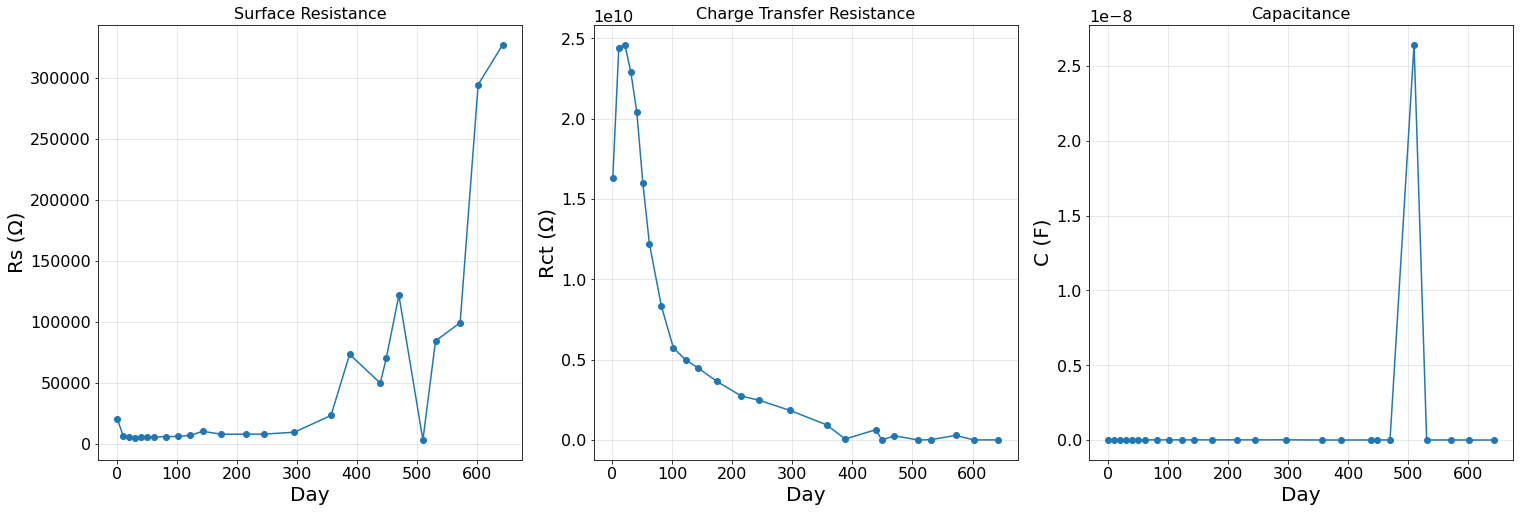

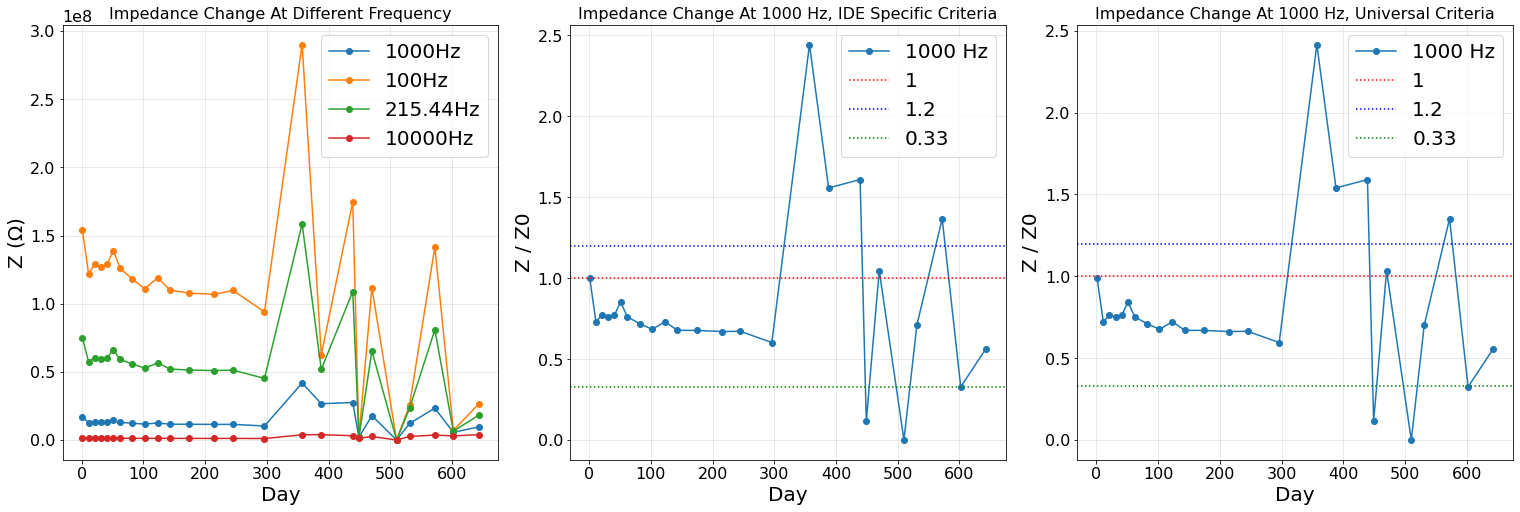


 

[1.45838116e+06 2.17935960e+06 3.20788880e+06 4.70771339e+06
 7.00959774e+06 1.01499705e+07 1.49702917e+07 2.18753619e+07
 3.19206099e+07 4.66422797e+07 6.89520794e+07 9.95892999e+07
 1.46222428e+08 2.15456603e+08 3.14337245e+08 4.47753461e+08
 6.52777272e+08 9.55383276e+08 1.35657331e+09 1.99901128e+09
 2.89710343e+09 4.54402478e+09 5.70910736e+09 1.03296903e+10
 1.28418826e+10]
[1.15085146e+03 1.43663137e+03 1.84631398e+03 2.39084740e+03
 3.21820708e+03 4.20952360e+03 5.81757613e+03 7.98563876e+03
 1.10319717e+04 1.53340562e+04 2.14802101e+04 2.96883867e+04
 4.10457279e+04 5.68617802e+04 7.86186293e+04 1.08337639e+05
 1.48740883e+05 2.04221968e+05 2.80386352e+05 3.83631767e+05
 5.26157120e+05 7.08288009e+05 9.60703497e+05 1.27195262e+06
 1.73234175e+06]


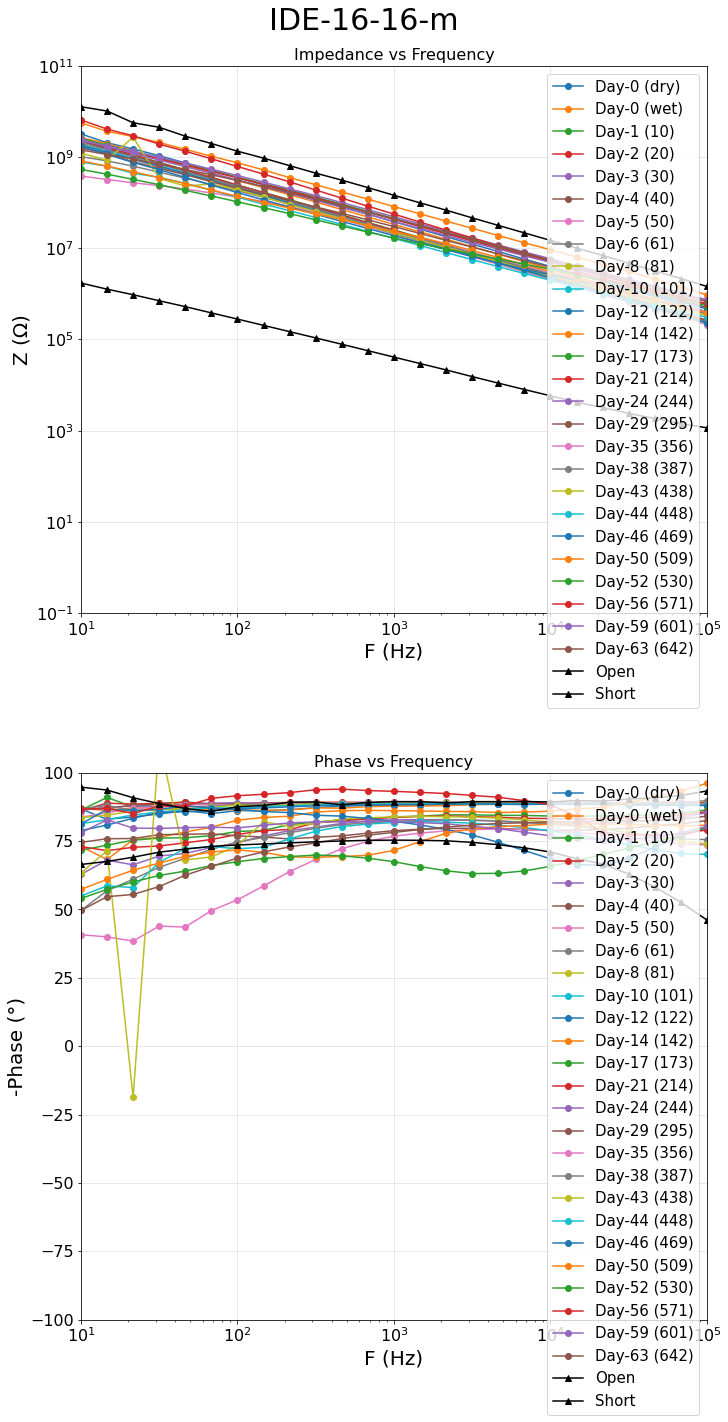

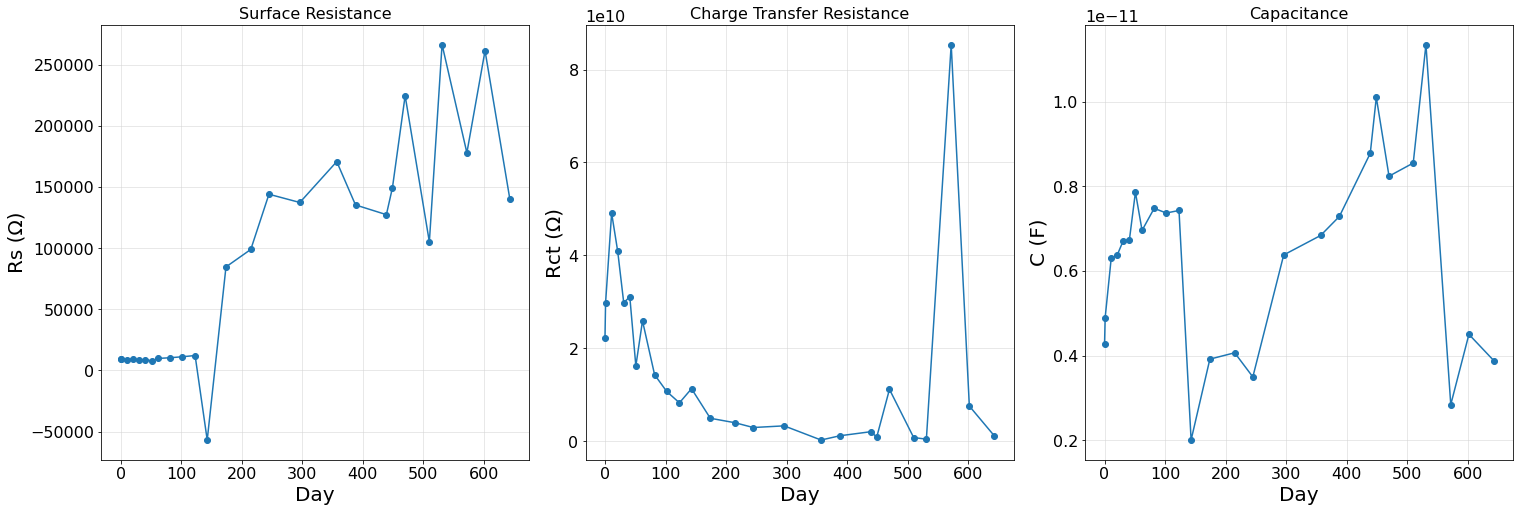

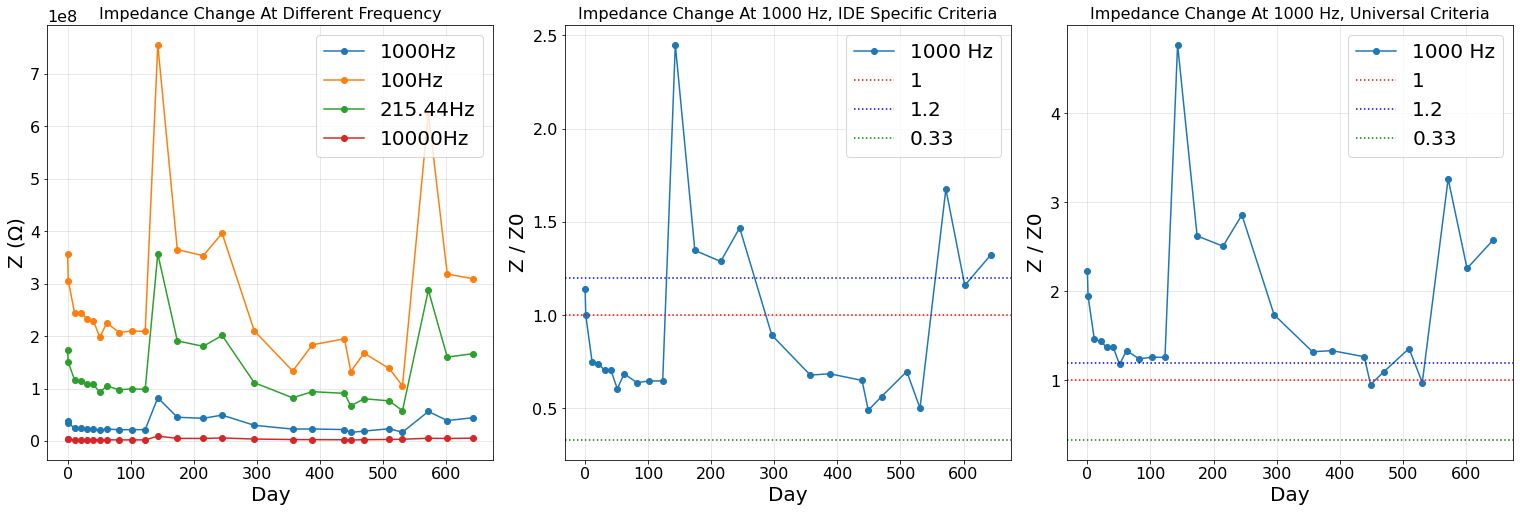


 

[2.56842677e+06 3.95482587e+06 5.86455430e+06 8.72593320e+06
 1.25049776e+07 1.84558128e+07 2.74229612e+07 3.93199588e+07
 5.76106796e+07 8.66437758e+07 1.23102006e+08 1.80568873e+08
 2.66283822e+08 3.92398963e+08 5.64555452e+08 8.43749593e+08
 1.24132132e+09 1.73714498e+09 2.48564883e+09 3.64202209e+09
 5.13641073e+09 8.76002114e+09 1.02092873e+10 1.62389770e+10
 2.57643814e+10]
[   580.6362858    668.8095246    789.0633727    958.0517555
   1194.435944    1534.498968    2009.713448    2625.421851
   3520.437728    4753.233777    6445.621553    8815.649483
  12184.34198    16734.98326    23096.4336     32005.16833
  44303.40628    61350.59253    84485.94383   115903.9019
 158468.5844    217129.0233    294986.7225    396899.9869
 529570.705    ]


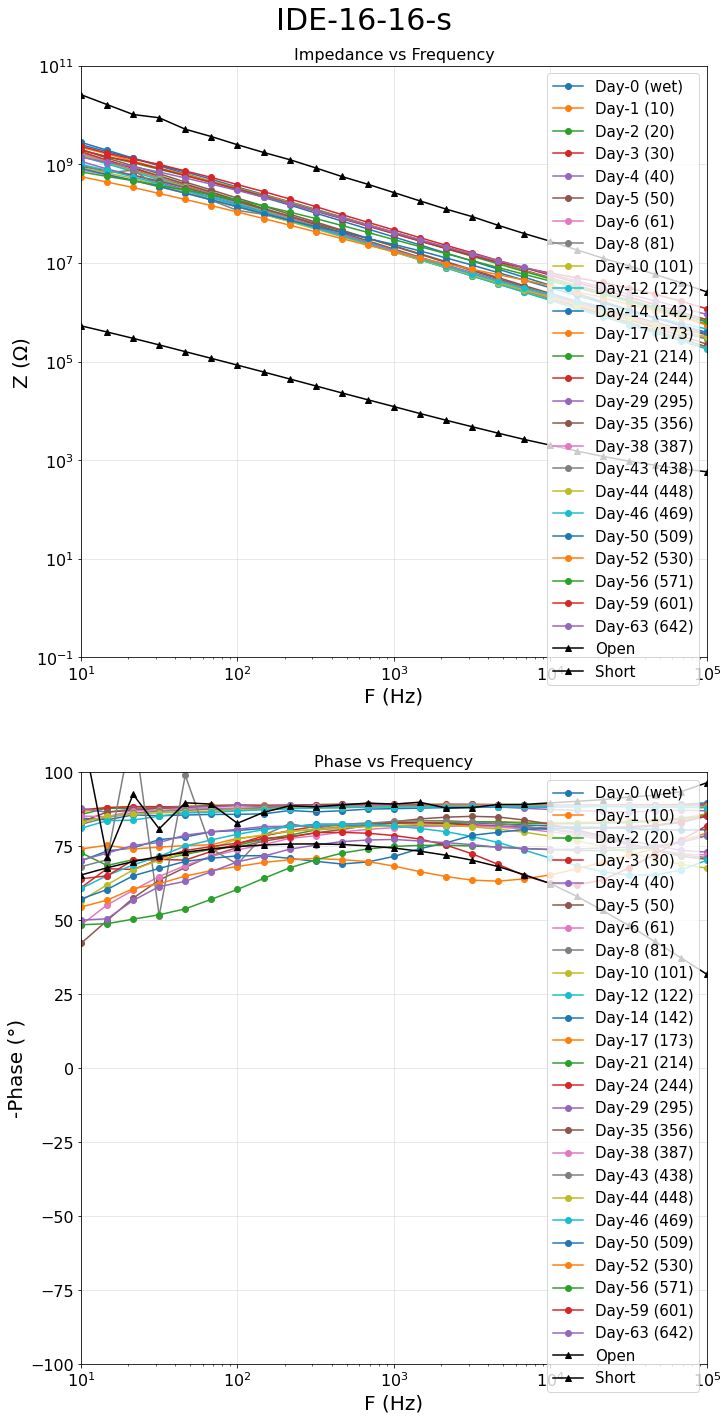

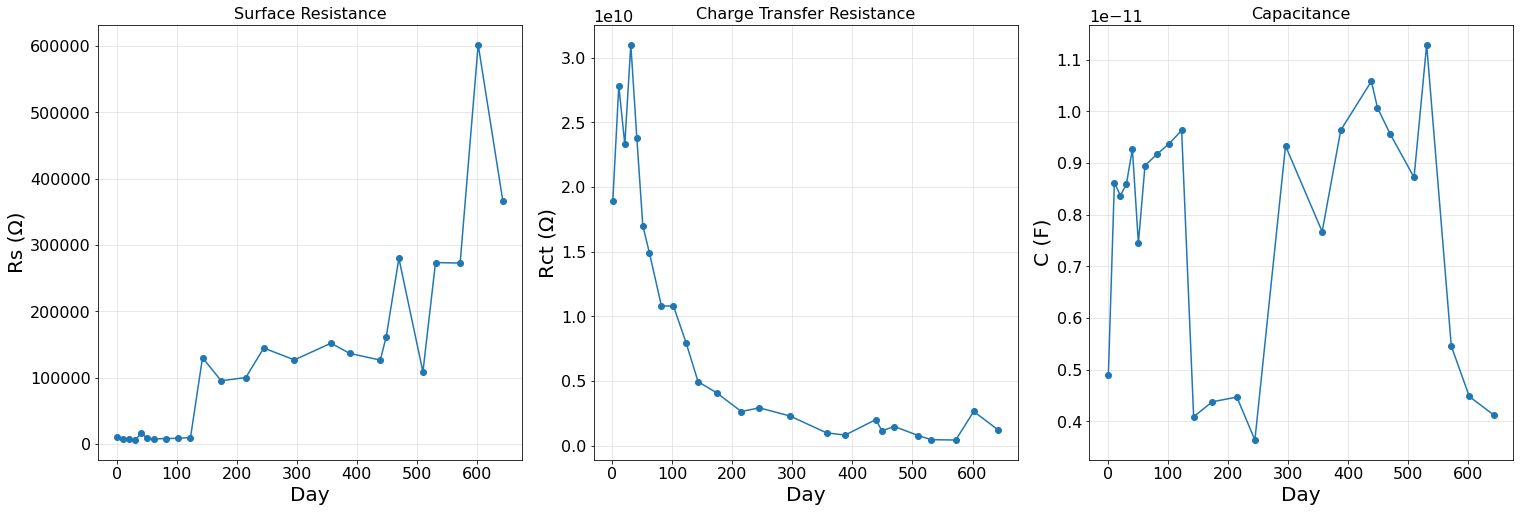

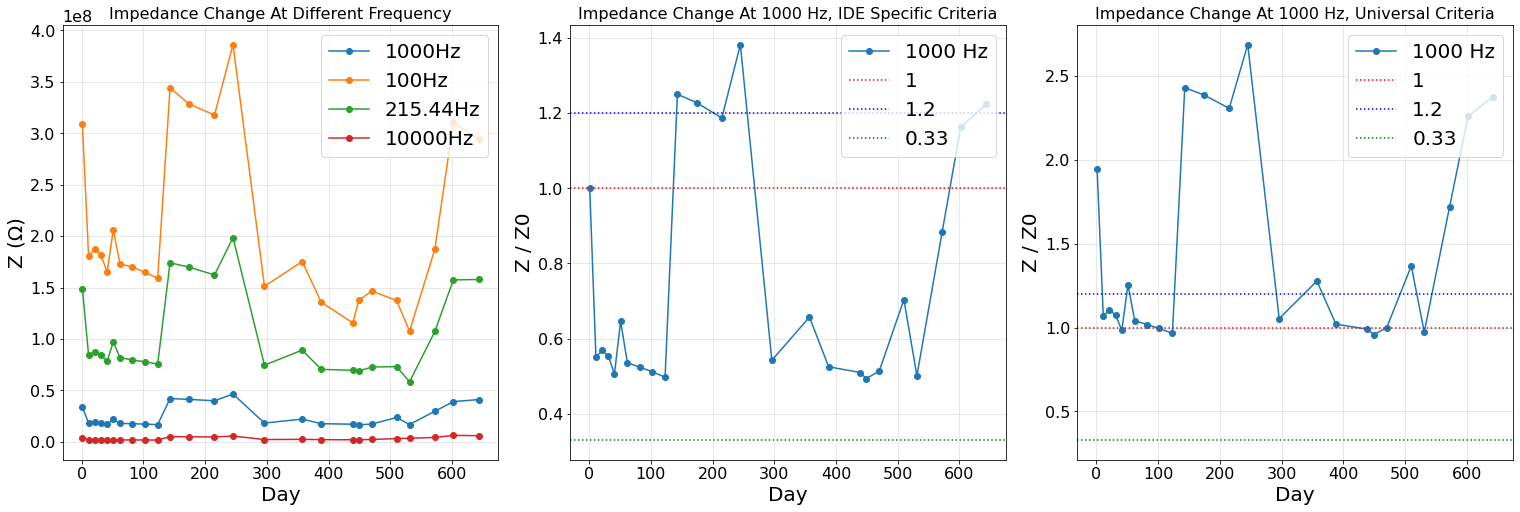


 

[1.45838116e+06 2.17935960e+06 3.20788880e+06 4.70771339e+06
 7.00959774e+06 1.01499705e+07 1.49702917e+07 2.18753619e+07
 3.19206099e+07 4.66422797e+07 6.89520794e+07 9.95892999e+07
 1.46222428e+08 2.15456603e+08 3.14337245e+08 4.47753461e+08
 6.52777272e+08 9.55383276e+08 1.35657331e+09 1.99901128e+09
 2.89710343e+09 4.54402478e+09 5.70910736e+09 1.03296903e+10
 1.28418826e+10]
[1.15085146e+03 1.43663137e+03 1.84631398e+03 2.39084740e+03
 3.21820708e+03 4.20952360e+03 5.81757613e+03 7.98563876e+03
 1.10319717e+04 1.53340562e+04 2.14802101e+04 2.96883867e+04
 4.10457279e+04 5.68617802e+04 7.86186293e+04 1.08337639e+05
 1.48740883e+05 2.04221968e+05 2.80386352e+05 3.83631767e+05
 5.26157120e+05 7.08288009e+05 9.60703497e+05 1.27195262e+06
 1.73234175e+06]


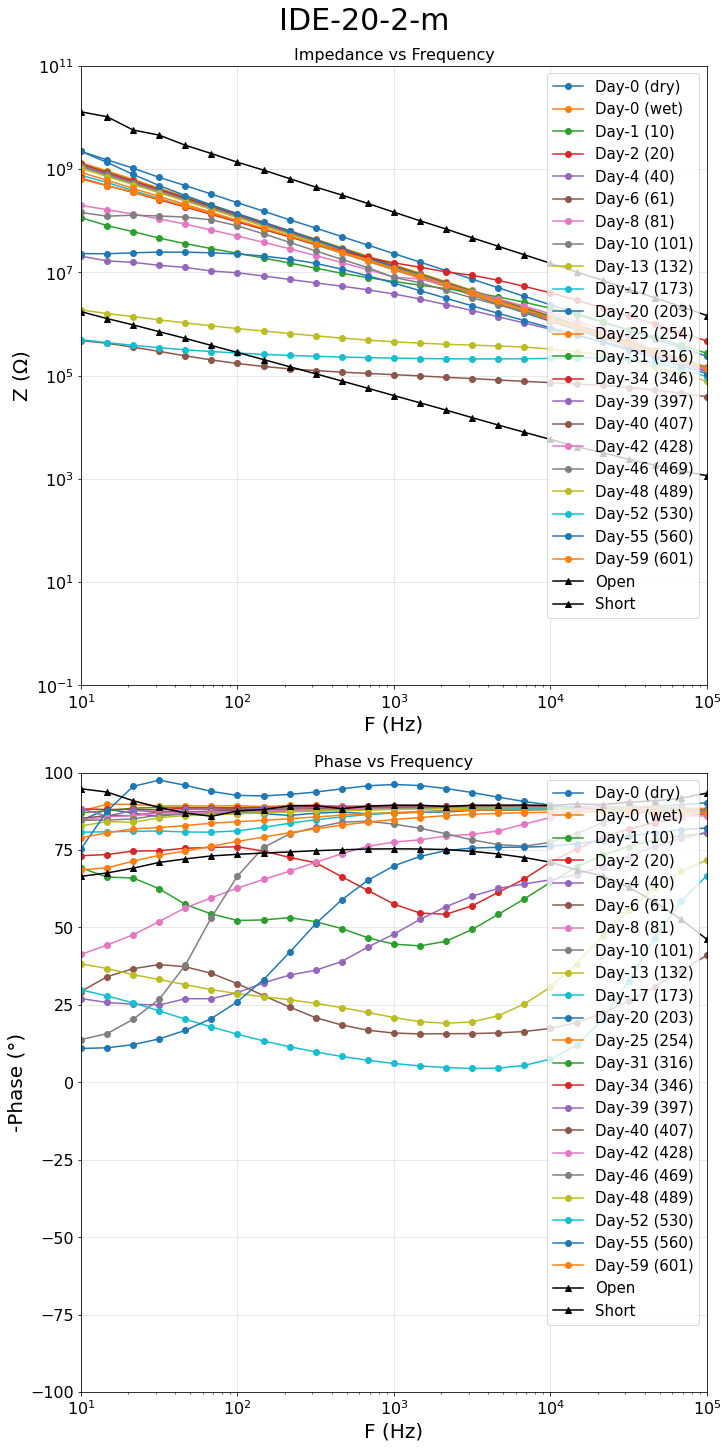

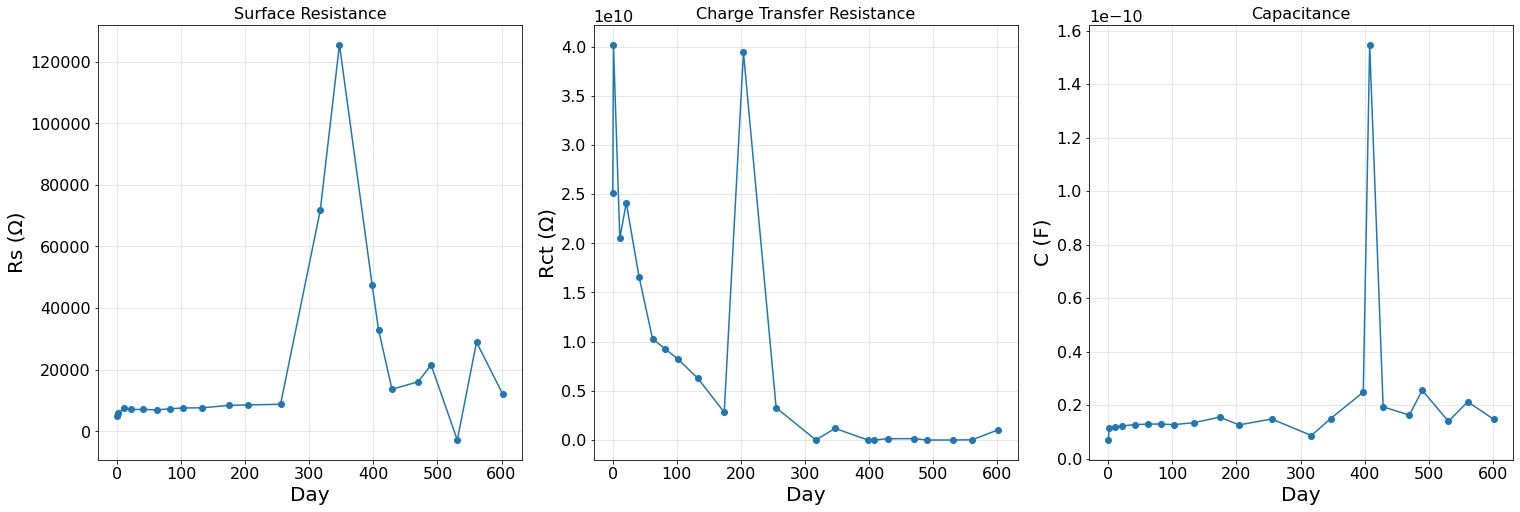

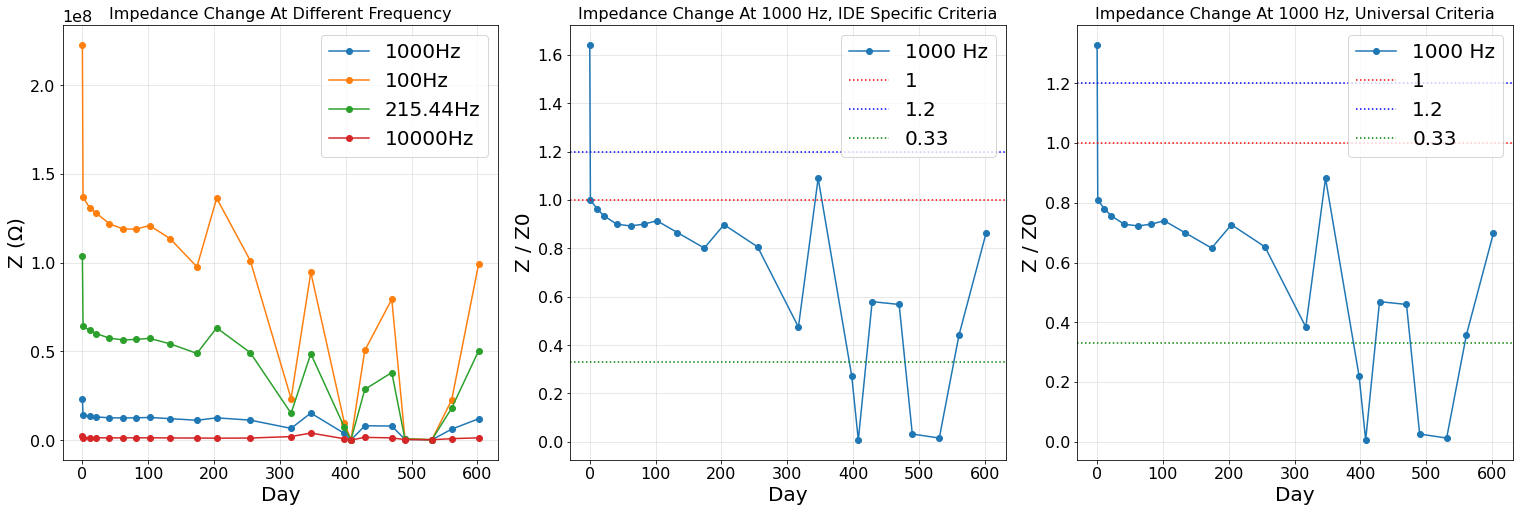


 

[2.56842677e+06 3.95482587e+06 5.86455430e+06 8.72593320e+06
 1.25049776e+07 1.84558128e+07 2.74229612e+07 3.93199588e+07
 5.76106796e+07 8.66437758e+07 1.23102006e+08 1.80568873e+08
 2.66283822e+08 3.92398963e+08 5.64555452e+08 8.43749593e+08
 1.24132132e+09 1.73714498e+09 2.48564883e+09 3.64202209e+09
 5.13641073e+09 8.76002114e+09 1.02092873e+10 1.62389770e+10
 2.57643814e+10]
[   580.6362858    668.8095246    789.0633727    958.0517555
   1194.435944    1534.498968    2009.713448    2625.421851
   3520.437728    4753.233777    6445.621553    8815.649483
  12184.34198    16734.98326    23096.4336     32005.16833
  44303.40628    61350.59253    84485.94383   115903.9019
 158468.5844    217129.0233    294986.7225    396899.9869
 529570.705    ]


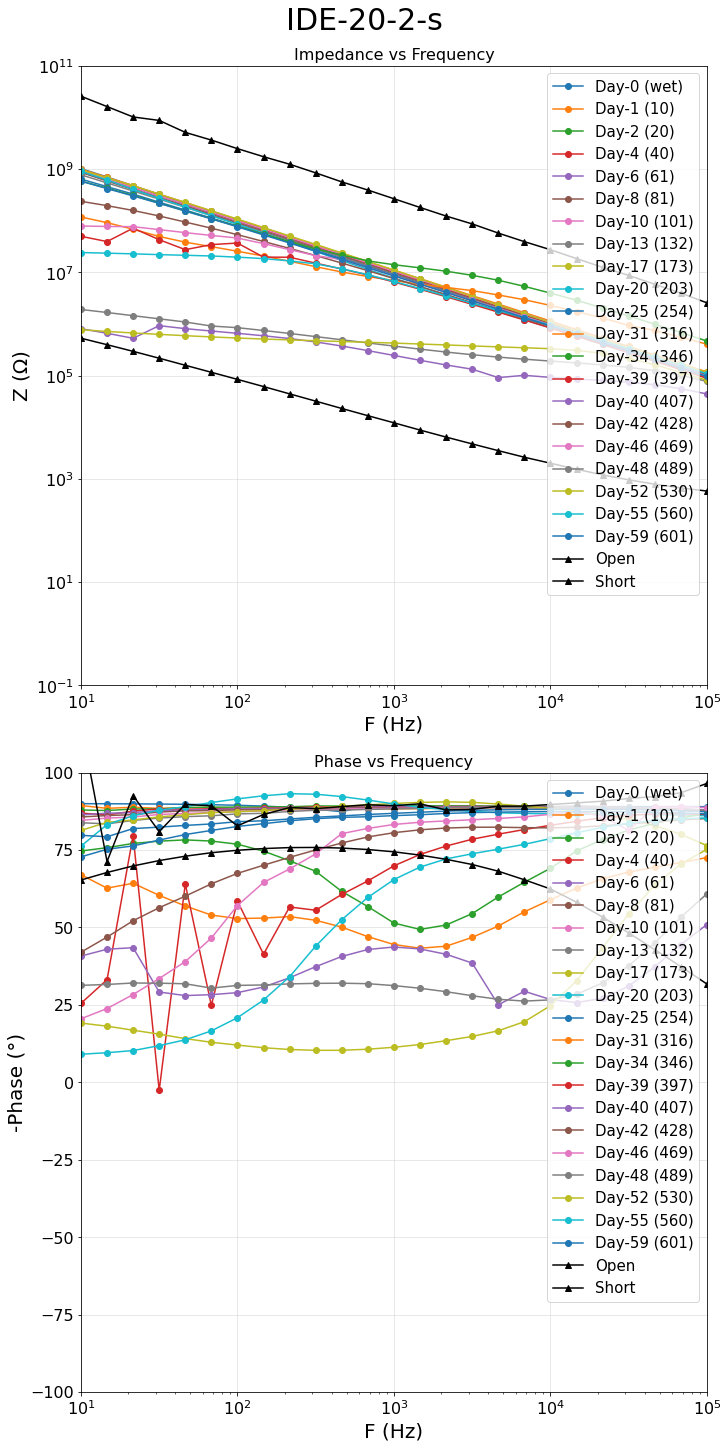

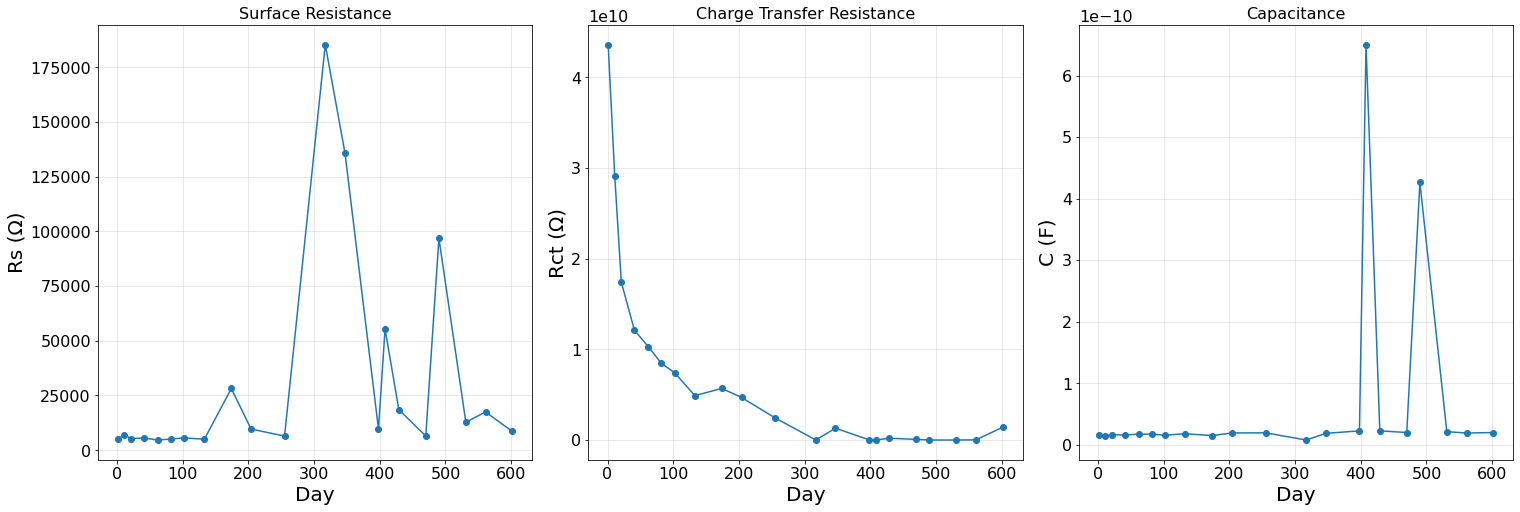

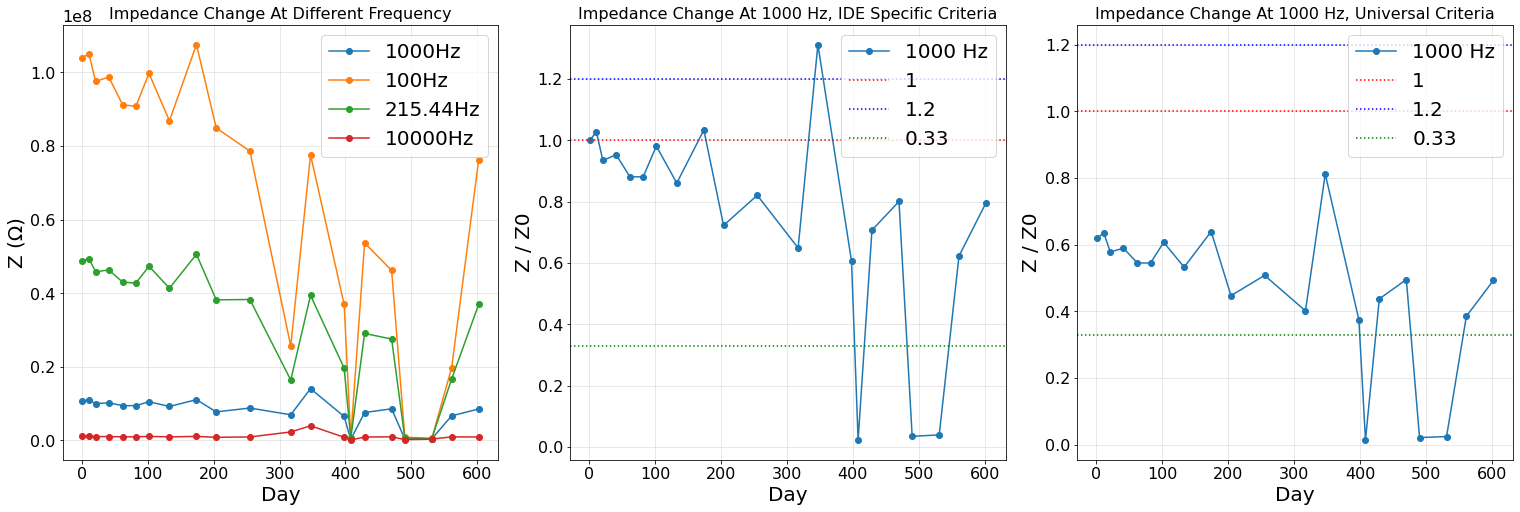


 

[1.45838116e+06 2.17935960e+06 3.20788880e+06 4.70771339e+06
 7.00959774e+06 1.01499705e+07 1.49702917e+07 2.18753619e+07
 3.19206099e+07 4.66422797e+07 6.89520794e+07 9.95892999e+07
 1.46222428e+08 2.15456603e+08 3.14337245e+08 4.47753461e+08
 6.52777272e+08 9.55383276e+08 1.35657331e+09 1.99901128e+09
 2.89710343e+09 4.54402478e+09 5.70910736e+09 1.03296903e+10
 1.28418826e+10]
[1.15085146e+03 1.43663137e+03 1.84631398e+03 2.39084740e+03
 3.21820708e+03 4.20952360e+03 5.81757613e+03 7.98563876e+03
 1.10319717e+04 1.53340562e+04 2.14802101e+04 2.96883867e+04
 4.10457279e+04 5.68617802e+04 7.86186293e+04 1.08337639e+05
 1.48740883e+05 2.04221968e+05 2.80386352e+05 3.83631767e+05
 5.26157120e+05 7.08288009e+05 9.60703497e+05 1.27195262e+06
 1.73234175e+06]


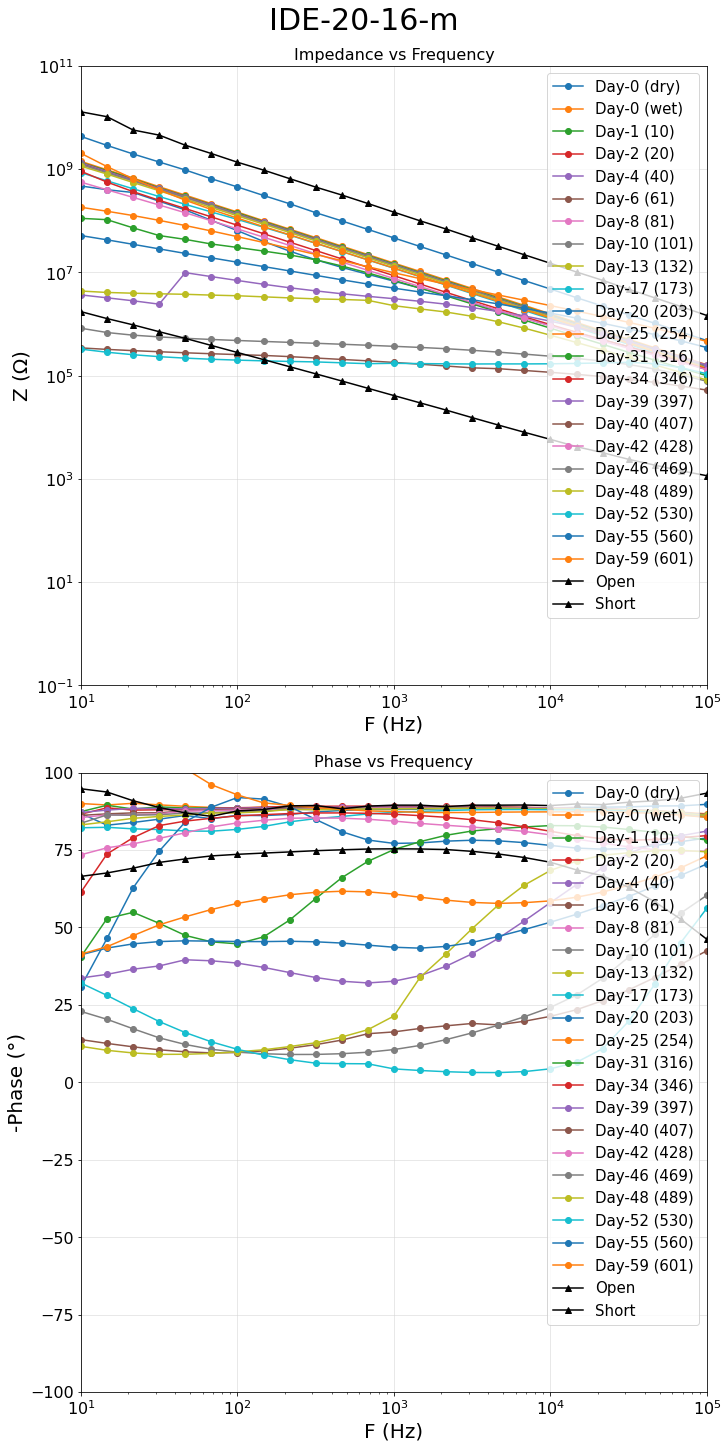

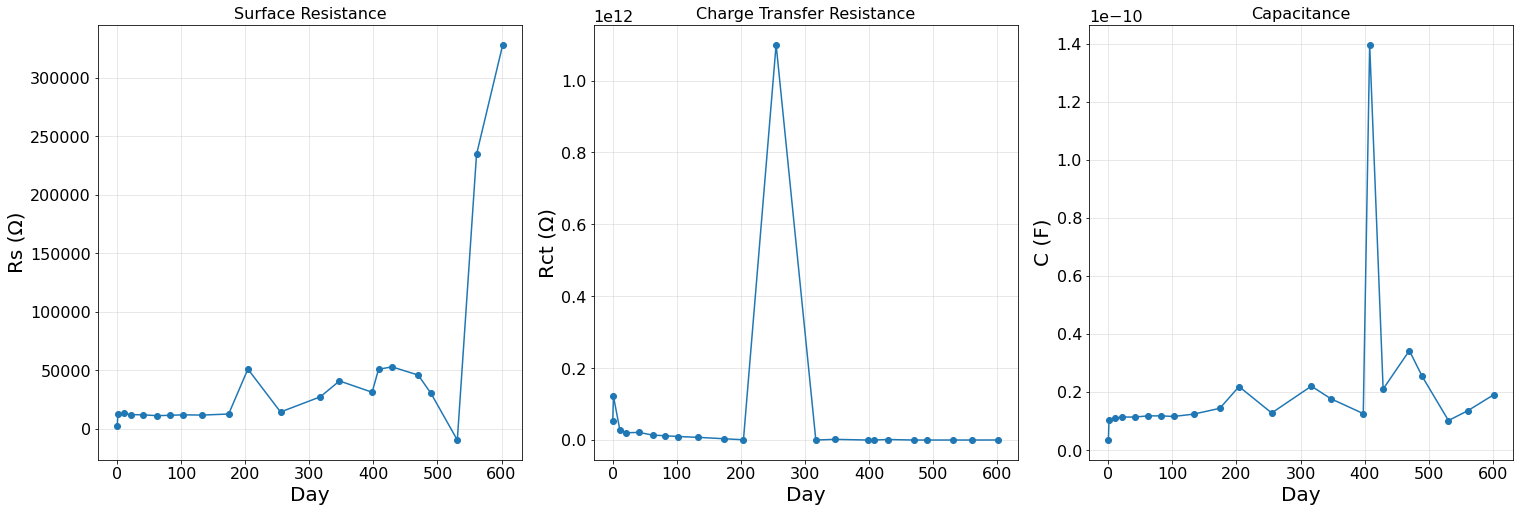

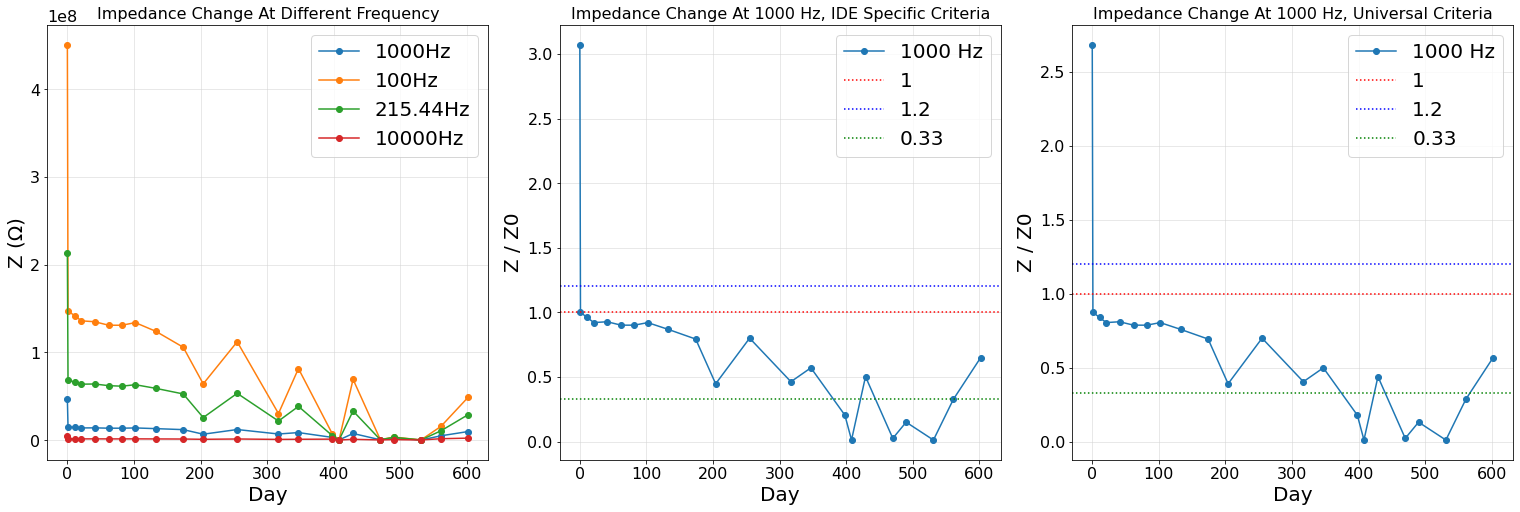


 

[2.56842677e+06 3.95482587e+06 5.86455430e+06 8.72593320e+06
 1.25049776e+07 1.84558128e+07 2.74229612e+07 3.93199588e+07
 5.76106796e+07 8.66437758e+07 1.23102006e+08 1.80568873e+08
 2.66283822e+08 3.92398963e+08 5.64555452e+08 8.43749593e+08
 1.24132132e+09 1.73714498e+09 2.48564883e+09 3.64202209e+09
 5.13641073e+09 8.76002114e+09 1.02092873e+10 1.62389770e+10
 2.57643814e+10]
[   580.6362858    668.8095246    789.0633727    958.0517555
   1194.435944    1534.498968    2009.713448    2625.421851
   3520.437728    4753.233777    6445.621553    8815.649483
  12184.34198    16734.98326    23096.4336     32005.16833
  44303.40628    61350.59253    84485.94383   115903.9019
 158468.5844    217129.0233    294986.7225    396899.9869
 529570.705    ]


In [ ]:
# Step 2: Initialize tested IDEs

# Read experiment date file.
date = "date.csv"
df_date = pd.read_csv(date)

# Initialize IDEs
#Old Devices
IDE_12 = IDE(12, [8], ["m","s"], "csv")
# IDE_14 = IDE(14, [2,4,8,16], ["m","s"], "csv")
IDE_16 = IDE(16, [2,4,8,16],["m","s"], "csv") #,16
IDE_20 = IDE(20, [2,16], ["m","s"], "csv")

#New Devices
IDE_22 = IDE(22, [2,4,8,16],["m","s"], "csv")
IDE_26 = IDE(26, [2,4,8,16],["m","s"], "csv")
IDE_27 = IDE(27, [2,4,8,16],["m","s"], "csv")
IDE_28 = IDE(28, [2,4,8,16],["m","s"], "csv")
IDE_31 = IDE(31, [2,4,8,16],["m","s"], "csv")

# Track device results
total_channels = 0
num_failed = 0
num_good_2 = 0
num_good_4 = 0
num_good_8 = 0
num_good_16 = 0

# List of all IDEs
IDE_list = [IDE_12, IDE_16, IDE_20, IDE_22, IDE_26, IDE_27, IDE_28, IDE_31]

# IDE_12 as an example

# Iterate through one IDE
date_idx = 0

# Graph Device Data
for ide in IDE_list:
    ide.setData()
    for file in ide.getDataFile():
        df = pd.read_csv(file)

        #First clean the data to only include the 25 items
        ide.cleanData(df)

        #Read the cleaned data
        df = pd.read_csv(file)

        #Extract Rs, Rct, and C
        Rs = ide.getRC(df, "Rs")
        Rct = ide.getRC(df, "Rct")
        C = ide.getRC(df, "C")
        
        #Get the summary graph for each IDE
        ide.plot_imped_phase(file, df, df_date, date_idx, Rs, Rct, C)
        
        date_idx += 1

print("GLOBAL_Z0_m_dry", GLOBAL_Z0_m_dry)
print("GLOBAL_Z0_m_wet", GLOBAL_Z0_m_wet)
print("GLOBAL_Z0_s_wet", GLOBAL_Z0_s_wet)

GLOBAL_df = pd.DataFrame({'Z0_m_dry': GLOBAL_Z0_m_dry, 'Z0_m_wet': GLOBAL_Z0_m_wet, "Z0_s_wet": GLOBAL_Z0_s_wet})

GLOBAL_df.to_csv("GLOBAL.csv", index=False)